In [58]:
#all in one 
# import data
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/Users/bingzhi/git/finrisk/cririsk'
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [59]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df
    

class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs
    

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

ROOT            = Path('/Users/bingzhi/git/finrisk/cririsk')

TRAIN_DIR       = ROOT / "dataset" / "train"
TEST_DIR        = ROOT / "dataset" / "test"

data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}



KeyboardInterrupt: 

In [ ]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
df_train = df_train.pipe(Pipeline.filter_cols)
gc.collect()

train data shape:	 (1526659, 861)


0

In [ ]:
cnt_encoding_cols = df_train.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

mappings = {}
for col in cnt_encoding_cols:
    mappings[col] = df_train.group_by(col).len()

df_train_lazy = df_train.select(mappings.keys()).lazy()
# df_train_lazy = pl.LazyFrame(df_train.select('case_id'))

for col, mapping in mappings.items():
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_train_lazy = df_train_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
    gc.collect()

del mappings
transformed_train = df_train_lazy.collect()

df_train = pl.concat([df_train, transformed_train.select("^*cnt$")], how='horizontal')
del transformed_train, cnt_encoding_cols

gc.collect()


0

In [18]:

df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]
df_train.drop(['requesttype_4525192L_cnt','max_empl_employedtotal_800L_cnt', 'max_empl_industry_691L_cnt'], axis=1, inplace=True)

Memory usage of dataframe is 5650.57 MB
Memory usage after optimization is: 2894.48 MB
Decreased by 48.8%
train data shape:	 (1526659, 586)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D', 'max_relationshiptoclient_415T_

dimention reduction

In [60]:
# dimention reduction
## bins and iv calculation
### only numerical to do auto bin by
import scorecardpy as sc
import warnings
warnings.filterwarnings('ignore')

#[cat_cols] [nums]
nums = df_train.select_dtypes(exclude='category').columns # only num colums
df_train_bin = df_train[nums] # filter num colums

# bin and IV cal take 20 mins around
bins = sc.woebin(df_train_bin, y='target', method='tree', max_num_bin=8, stop_limit=0.1)
#Binning on 1526659 rows and 328 columns in 00:07:19

df_woe = sc.woebin_ply(df_train_bin, bins) # dict with bin and iv woe
#Woe transformating on 1526659 rows and 327 columns in 00:06:04

iv_table = sc.iv(df_woe, y='target')
#iv_table.to_csv("output.csv", index=False)
#iv_table['info_value']


[INFO] creating woe binning ...


KeyboardInterrupt: 

In [7]:
# filter
iv_dict = iv_table.set_index('variable')['info_value'].to_dict()
selected_features = [k for k, v in iv_dict.items() if v > 0.02]
df_raw_selected_iv_over2 = df_woe[selected_features]

In [8]:
df_final_transposed = df_raw_selected_iv_over2.T
index_df = pd.DataFrame(df_final_transposed.index, columns=['IndexColumn'])

In [9]:
#fa
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=8, random_state=42)

# fit
fa.fit(df_final_transposed)

# score
factor_scores = fa.transform(df_final_transposed)
# df
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor_{i+1}' for i in range(factor_scores.shape[1])])
print(factor_scores_df.head(5))

#factor_scores_df.to_csv("fa.csv", index=False)

   Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  Factor_7  \
0  0.832480  2.278747 -2.078922 -1.744968 -0.730185  0.869070 -0.316721   
1  0.839641  3.456938  3.904444  0.363257 -0.483438 -0.536353  0.358927   
2  0.875146  2.973527  3.830736  0.248495 -0.501184 -0.393716  0.035222   
3  0.807361  2.547567 -2.240419 -2.015621 -0.832694  1.012046 -0.708954   
4  0.671324  2.096666 -1.940768 -1.381369  0.033467  0.110991  0.880838   

   Factor_8  
0 -0.729357  
1  0.248923  
2  0.141883  
3 -0.619382  
4  0.622743  


# selected feature
##### maxdpdlast24m_143P, avgdpdtolclosure24_3658938P, pctinstlsallpaidlate1d_3546856L,mean_pmts_dpd_303P,mean_pmts_overdue_1152A,mean_pmts_dpd_1073P,max_numberofoverdueinstlmax_1039L,lastrejectdate_50D, lastrejectreason_759M_cnt, lastcancelreason_561M_cnt, max_birth_259D, mean_employedfrom_700D, max_incometype_1044T_cnt ,maxdbddpdtollast12m_3658940P

In [61]:
slect_for_smote_features = ['target','maxdpdlast24m_143P', 'avgdpdtolclosure24_3658938P', 'pctinstlsallpaidlate1d_3546856L', 'mean_pmts_dpd_303P', 'mean_pmts_overdue_1152A', 'mean_pmts_dpd_1073P', 'max_numberofoverdueinstlmax_1039L', 'lastrejectdate_50D', 'lastrejectreason_759M_cnt', 'lastcancelreason_561M_cnt', 'max_birth_259D', 'mean_employedfrom_700D', 'max_incometype_1044T_cnt', 'maxdbddpdtollast12m_3658940P','max_sex_738L']
df_smote_pre =  df_train[slect_for_smote_features]
df_smote_pre['max_sex_738L'] = df_smote_pre['max_sex_738L'].replace({'F': "1", 'M': "0"})


In [28]:
y = df_smote_pre['target']
X = df_smote_pre.drop('target', axis=1)


In [34]:
#drop method
from imblearn.over_sampling import SMOTENC
df_clean = df_train[slect_for_smote_features].dropna()
y_drop = df_clean['target']
X_drop = df_clean.drop('target', axis=1)
smote_nc = SMOTENC(categorical_features=['max_sex_738L'], random_state=42)
X_drop_smote, y_drop_smote = smote_nc.fit_resample(X_drop, y_drop)


In [36]:
df_merge_smotenc_drop = pd.concat([X_drop_smote, y_drop_smote], axis=1)

In [ ]:
import scorecardpy as sc
import warnings
warnings.filterwarnings('ignore')

In [43]:
# bin and IV cal take 20 mins around
smote_bins_dropna = sc.woebin(df_merge_smotenc_drop, y='target', method='tree', max_num_bin=8, stop_limit=0.6)
#Binning Binning on 564448 rows and 16 columns in 00:00:12

df_smote_woe_dropna = sc.woebin_ply(df_merge_smotenc_drop, smote_bins_dropna) # dict with bin and iv woe
#Woe transformating 

[INFO] creating woe binning ...


/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

Binning on 564448 rows and 16 columns in 00:00:12
[INFO] converting into woe values ...


In [44]:
output_file = 'bin_dropna.txt'
with open(output_file, "w") as file:
    for key, value in smote_bins_dropna.items():
        file.write(f"{key}: {value}\n")

In [47]:
df_clean = df_train[slect_for_smote_features].dropna()
df_clean_bin = sc.woebin_ply(df_clean, smote_bins_dropna) # dict with bin and iv woe

[INFO] converting into woe values ...


In [53]:
#df_clean_bin
y = df_clean_bin
y = y.drop(['target'], axis=1)
X = df_clean_bin

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Configuration for the logistic regression
logistic_params = {
    "random_state": 42,
    "max_iter": 100,
    "solver": 'liblinear'
}

# Function to create a logistic regression model pipeline
def create_model(df, strategy='median', logistic_params=logistic_params):
    simple_imputer = SimpleImputer(strategy=strategy)
    num_pipeline = Pipeline([
        ('imputer', simple_imputer),
        ('scaler', StandardScaler())
    ])
    # Apply preprocessing to all columns in the dataframe
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, df.columns),
        ])
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(**logistic_params))
    ])
    return model

# Function to perform training using cross-validation and evaluate on a test set
def train_and_evaluate_model(df, target, test_size=0.05, random_state=42):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    model = create_model(X_train)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Iterate over each fold
    for train_index, test_index in cv.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Train the model on the fold
        model.fit(X_fold_train, y_fold_train)
        
        # Evaluate the model on the fold
        y_pred = model.predict(X_fold_test)
        print("Confusion Matrix for the fold:")
        print(confusion_matrix(y_fold_test, y_pred))
        print(classification_report(y_fold_test, y_pred))
    
    # Final test on the holdout test set
    y_pred_test = model.predict(X_test)
    print("Final Test Set Results:")
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))

    return model

# Example usage:
# df is your DataFrame containing the data with a 'target' column
# model = train_and_evaluate_model(df, 'target')


In [57]:
train_and_evaluate_model(X,'target',0.05)

Confusion Matrix for the fold:
[[53623     0]
 [ 2352     0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     53623
           1       0.00      0.00      0.00      2352

    accuracy                           0.96     55975
   macro avg       0.48      0.50      0.49     55975
weighted avg       0.92      0.96      0.94     55975

Confusion Matrix for the fold:
[[53623     0]
 [ 2352     0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     53623
           1       0.00      0.00      0.00      2352

    accuracy                           0.96     55975
   macro avg       0.48      0.50      0.49     55975
weighted avg       0.92      0.96      0.94     55975

Confusion Matrix for the fold:
[[53622     0]
 [ 2353     0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     53622
           1       0.00      0.00      0.00      23

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe',
       'mean_pmts_overdue_1152A_woe', 'lastcancelreason_561M_cnt_woe',
       'max_birth_259D_woe', 'mean_employedfrom_700D_woe',
       'avgdpdtolclosure24_3658938P_woe', 'maxdpdlast24m_143P_woe',
       'mean_pmts_dpd_1073P_woe', 'max_sex_738L_woe',
       'pctinstlsallpaidlate1d_3546856L_woe',
       'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe',
       'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [62]:
import scorecardpy as sc
import warnings
warnings.filterwarnings('ignore')

# bin and IV cal take 20 mins around
smote_bins = sc.woebin(df_smote_pre, y='target', method='tree', max_num_bin=8, stop_limit=0.1)
#Binning on 1526659 rows and 16 columns in 00:00:27

df_smote_woe = sc.woebin_ply(df_smote_pre, smote_bins) # dict with bin and iv woe
#Woe transformating on 1526659 rows and 15 columns in 00:00:20

[INFO] creating woe binning ...


/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/Users/bingzhi/miniforge3/envs/ml/lib/python3.10/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future v

Binning on 1526659 rows and 16 columns in 00:00:29
[INFO] converting into woe values ...
Woe transformating on 1526659 rows and 15 columns in 00:00:22


In [65]:
select_smote_wOsex_wOalter = ['target','maxdpdlast24m_143P_woe', 'avgdpdtolclosure24_3658938P_woe', 'pctinstlsallpaidlate1d_3546856L_woe', 'mean_pmts_dpd_303P_woe', 'mean_pmts_overdue_1152A_woe', 'mean_pmts_dpd_1073P_woe', 'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe', 'lastrejectreason_759M_cnt_woe', 'lastcancelreason_561M_cnt_woe', 'max_birth_259D_woe', 'maxdbddpdtollast12m_3658940P_woe']
#alternative data = 'mean_employedfrom_700D_woe', 'max_incometype_1044T_cnt_woe'
df_smote_wOsex_wOalter = df_smote_woe[select_smote_wOsex_wOalter]
df_smote_wsex_walter = df_smote_woe
df_smote_wsex_wOalter = df_smote_woe.drop(columns=['mean_employedfrom_700D_woe', 'max_incometype_1044T_cnt_woe'])
df_smote_wOsex_walter = df_smote_woe.drop(columns=['max_sex_738L_woe'])

In [22]:
df_smote_woe.to_csv("df_binning_data_final.csv", index=False)

In [27]:
output_file = "smote_bins.txt"
with open(output_file, "w") as file:
    for key, value in smote_bins.items():
        file.write(f"{key}: {value}\n")

In [63]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split,cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

catboost

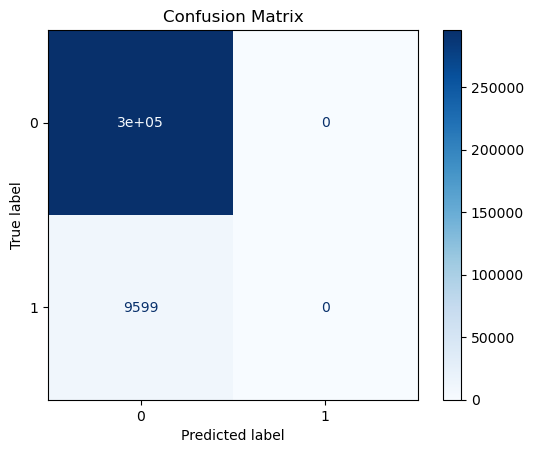

AUC Score for this fold: 0.7679336190052026
Accuracy for this fold: 0.9685620897907851


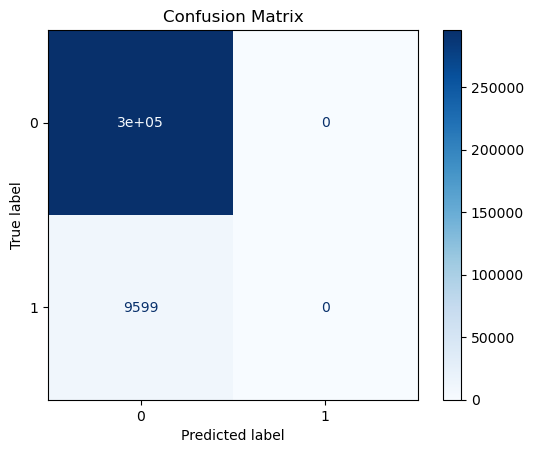

AUC Score for this fold: 0.7701797491909113
Accuracy for this fold: 0.9685620897907851


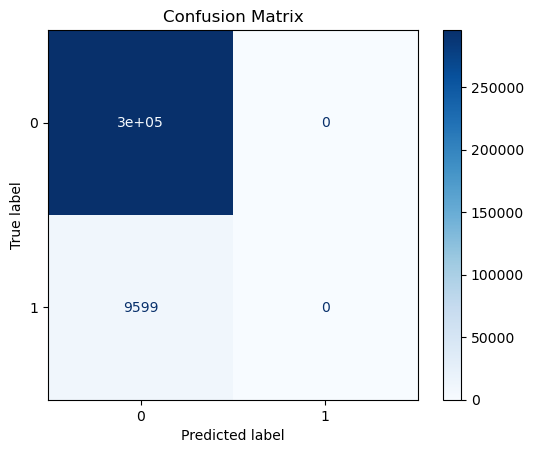

AUC Score for this fold: 0.7698054477048224
Accuracy for this fold: 0.9685620897907851


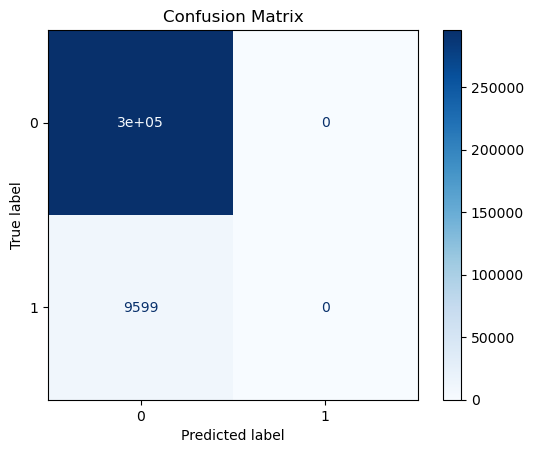

AUC Score for this fold: 0.7682431481166154
Accuracy for this fold: 0.9685620897907851


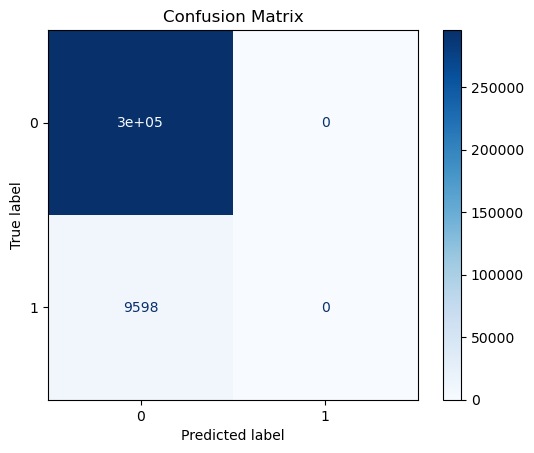

AUC Score for this fold: 0.7673402080041609
Accuracy for this fold: 0.9685652619616089
Average CV AUC Score: 0.7687004344043424
Average CV Accuracy Score: 0.9685627242249499


In [231]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
df_smote_wOsex_walter
y = df_smote_wOsex_walter['target']
X = df_smote_wOsex_walter.drop(columns=['target'])
# Example data setup
# X_train: feature set, y_train: target set
# Assume X_train and y_train are already defined and properly preprocessed

# Define the CatBoost classifier
cb_model = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1, 
    depth=6,
    loss_function='Logloss',
    verbose=False,
    random_seed=42
)

# Setup for cross-validation
n_splits = 5
cv_scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Perform cross-validation
cv_scores_auc = []
cv_scores_accuracy = []  # List to store each fold's accuracy

for train_index, test_index in kf.split(X, y):
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    cb_model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold), use_best_model=True)
    
    # Predict probabilities and convert to class labels
    y_pred_proba = cb_model.predict_proba(X_valid_fold)[:, 1]
    y_pred_labels = (y_pred_proba > 0.5).astype(int)
    
    # Calculate AUC score
    auc = roc_auc_score(y_valid_fold, y_pred_proba)
    cv_scores_auc.append(auc)  # Store AUC score for this fold
    
    # Calculate accuracy
    accuracy = accuracy_score(y_valid_fold, y_pred_labels)
    cv_scores_accuracy.append(accuracy)  # Store accuracy for this fold
    
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_valid_fold, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    print(f"AUC Score for this fold: {auc}")
    print(f"Accuracy for this fold: {accuracy}")

# Print average AUC score and average accuracy across all folds
print("Average CV AUC Score:", np.mean(cv_scores_auc))
print("Average CV Accuracy Score:", np.mean(cv_scores_accuracy))

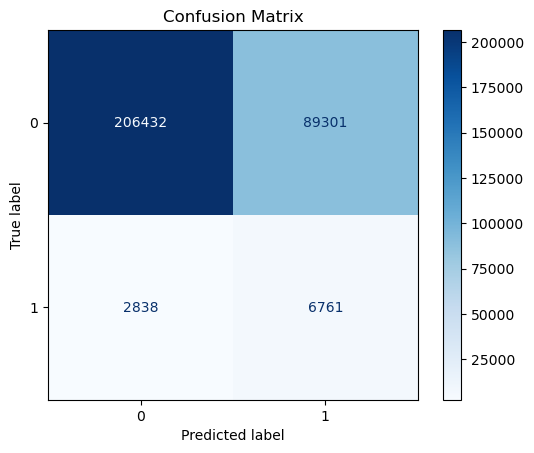

AUC Score for this fold: 0.7695404872937641
Accuracy for this fold: 0.6982333983991197


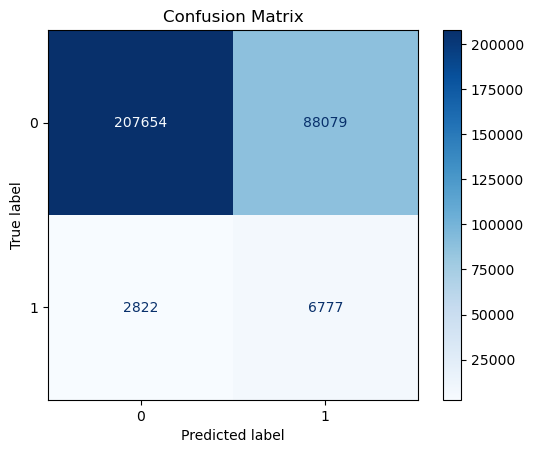

AUC Score for this fold: 0.7715739087519954
Accuracy for this fold: 0.7022880012576475


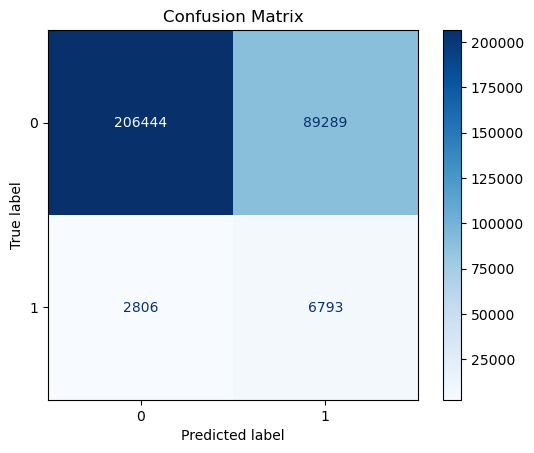

AUC Score for this fold: 0.7710064480495289
Accuracy for this fold: 0.6983775038318945


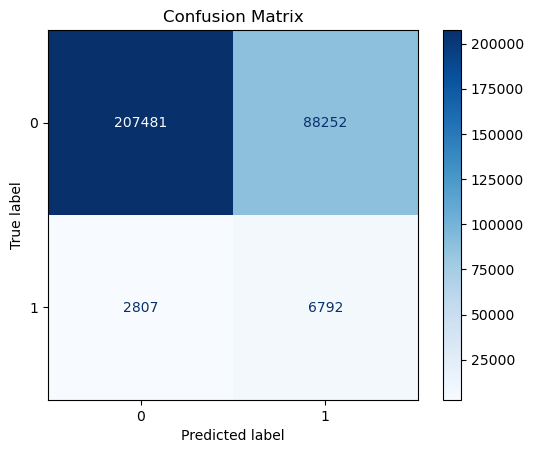

AUC Score for this fold: 0.7703587116210906
Accuracy for this fold: 0.7017705317490469


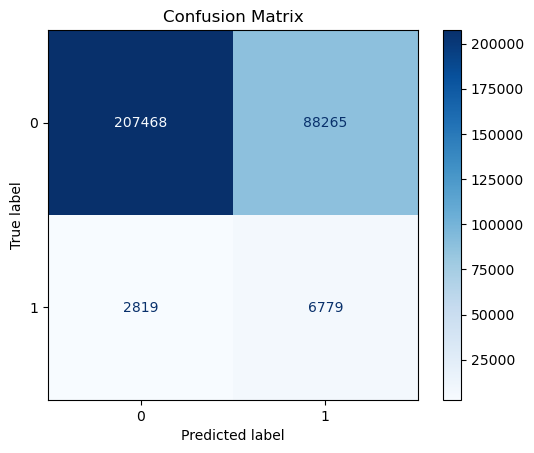

AUC Score for this fold: 0.7695839584557593
Accuracy for this fold: 0.7016876766525508
Average CV AUC Score: 0.7704127028344276
Average CV Accuracy Score: 0.7004714223780519


In [238]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_smote_wOsex_walter is your DataFrame with the data
X = df_smote_wOsex_walter
y = X['target']
X = X.drop(columns=['target'])

# Define the CatBoost classifier
cb_model = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1, 
    depth=6,
    loss_function='Logloss',
    verbose=False,
    random_seed=42
)

# Setup for cross-validation
n_splits = 5
cv_scores_auc = []
cv_scores_accuracy = []  # List to store each fold's accuracy
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
ros = RandomOverSampler(random_state=42)  # Random oversampler for handling imbalance

for train_index, test_index in kf.split(X, y):
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply RandomOverSampler to the training data
    X_train_ros, y_train_ros = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit the model on oversampled data
    cb_model.fit(X_train_ros, y_train_ros, eval_set=(X_valid_fold, y_valid_fold), use_best_model=True)
    
    # Predict probabilities and convert to class labels
    y_pred_proba = cb_model.predict_proba(X_valid_fold)[:, 1]
    y_pred_labels = (y_pred_proba > 0.5).astype(int)
    
    # Calculate AUC score
    auc = roc_auc_score(y_valid_fold, y_pred_proba)
    cv_scores_auc.append(auc)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_valid_fold, y_pred_labels)
    cv_scores_accuracy.append(accuracy)
    
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_valid_fold, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    print(f"AUC Score for this fold: {auc}")
    print(f"Accuracy for this fold: {accuracy}")

# Print average AUC score and average accuracy across all folds
print("Average CV AUC Score:", np.mean(cv_scores_auc))
print("Average CV Accuracy Score:", np.mean(cv_scores_accuracy))


In [167]:
#add over sampling
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
num_features = X.columns
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
    ])
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=100))
])

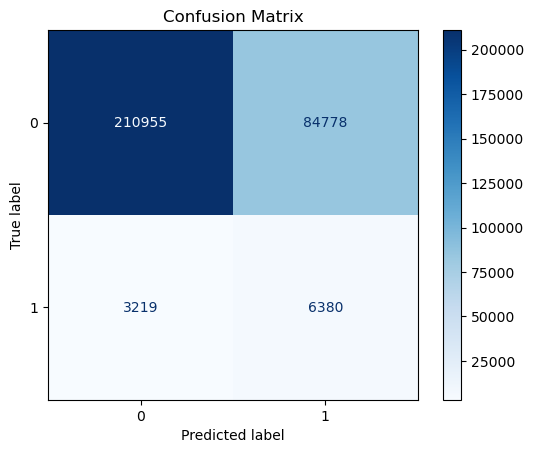

AUC Score for this fold: 0.7534193765901509
Accuracy for this fold: 0.7117989598207852


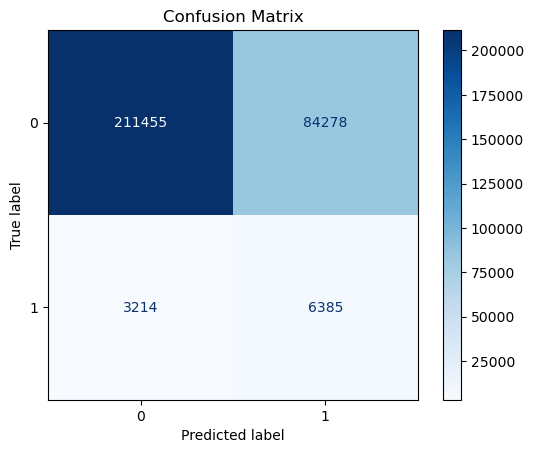

AUC Score for this fold: 0.7558015308058388
Accuracy for this fold: 0.7134528971742234


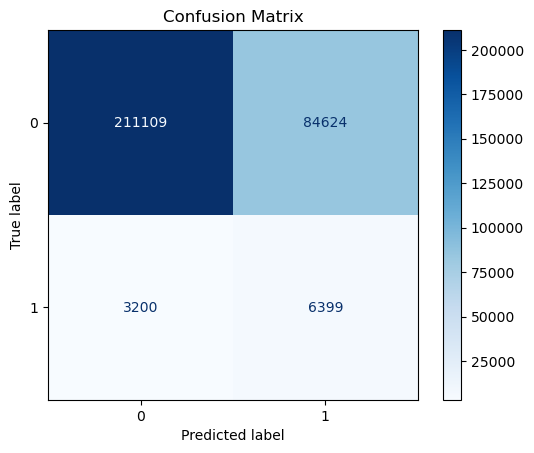

AUC Score for this fold: 0.755424565815111
Accuracy for this fold: 0.712365556181468


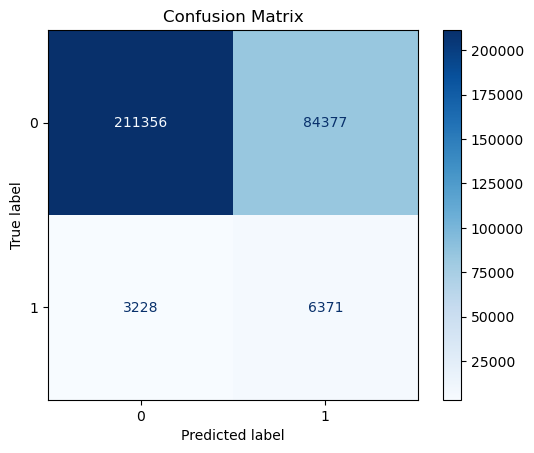

AUC Score for this fold: 0.7536745682342291
Accuracy for this fold: 0.71308280822187


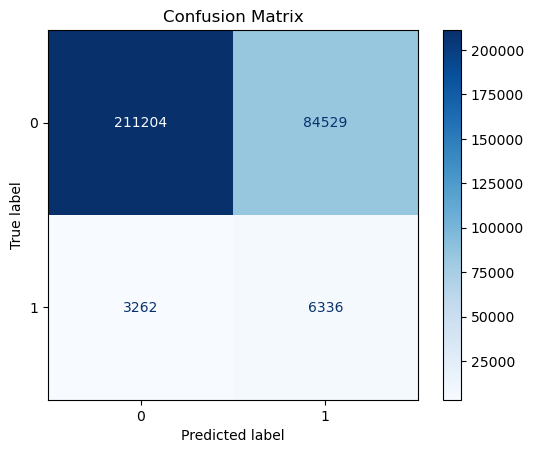

AUC Score for this fold: 0.7527666618785761
Accuracy for this fold: 0.712472693568619
Average CV AUC Score: 0.7542173406647812
Average CV Accuracy Score: 0.7126345829933931


In [232]:
df_smote_wOsex_walter
y = df_smote_wOsex_walter['target']
X = df_smote_wOsex_walter.drop(columns=['target'])
def get_model(X,y):
    df_list = [col for col in X.columns]
    # 定义过采样和模型训练的管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), df_list),
        ])
    
    # Defining the imbalanced-learn pipeline with oversampling and logistic regression
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', LogisticRegression())
    ])
    
    model = pipeline.fit(X, y)

    return model
    
cv_scores_auc = []
cv_scores_accuracy = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X, y):
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]
    
    # 使用管道训练模型
    pipeline.fit(X_train_fold, y_train_fold)
    
    # 预测验证集
    y_pred_proba = pipeline.predict_proba(X_valid_fold)[:, 1]
    y_pred_labels = pipeline.predict(X_valid_fold)
    
    # 计算并存储AUC和准确度
    auc = roc_auc_score(y_valid_fold, y_pred_proba)
    accuracy = accuracy_score(y_valid_fold, y_pred_labels)
    cv_scores_auc.append(auc)
    cv_scores_accuracy.append(accuracy)
    
    # 显示混淆矩阵
    cm = confusion_matrix(y_valid_fold, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    print(f"AUC Score for this fold: {auc}")
    print(f"Accuracy for this fold: {accuracy}")

# 打印所有折的平均AUC和准确度
print("Average CV AUC Score:", np.mean(cv_scores_auc))
print("Average CV Accuracy Score:", np.mean(cv_scores_accuracy))


In [239]:
catboost = cb_model.fit(X,y)

In [235]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe',
       'mean_pmts_overdue_1152A_woe', 'lastcancelreason_561M_cnt_woe',
       'max_birth_259D_woe', 'mean_employedfrom_700D_woe',
       'avgdpdtolclosure24_3658938P_woe', 'maxdpdlast24m_143P_woe',
       'mean_pmts_dpd_1073P_woe', 'pctinstlsallpaidlate1d_3546856L_woe',
       'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe',
       'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe'],
      dtype='object'))])),
                ('oversample', RandomOverSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

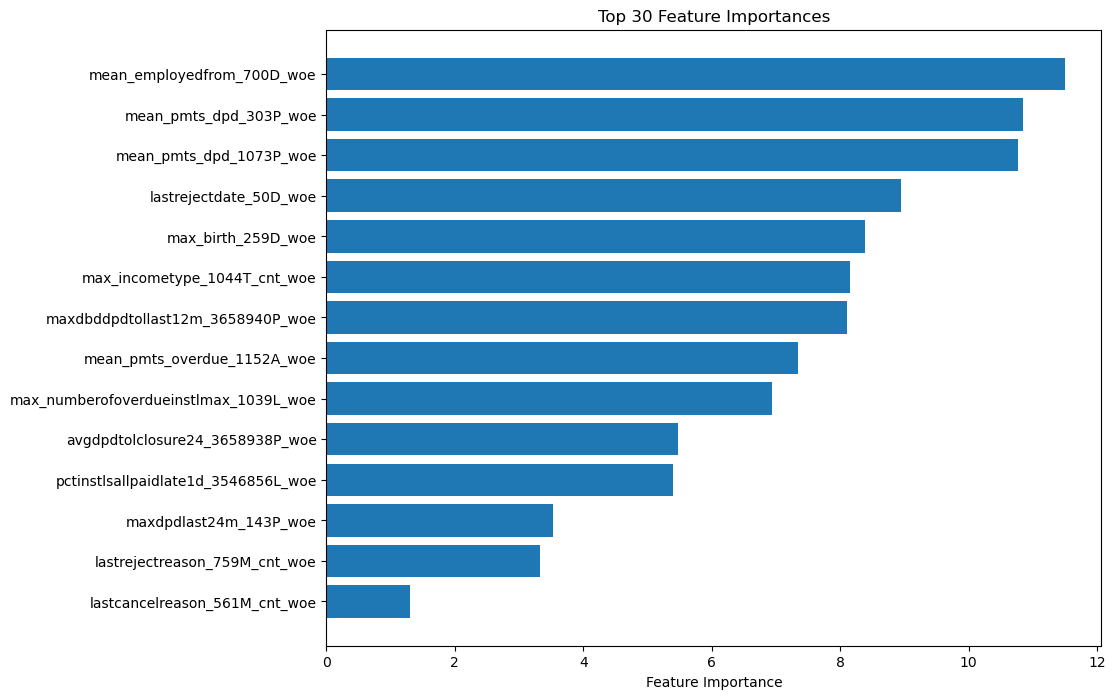

In [243]:
# Assuming 'catboost' is your trained CatBoost model
feature_importances = catboost.get_feature_importance(type='FeatureImportance')
feature_names = X.columns  # Assuming X is your feature DataFrame

# Creating a DataFrame to store and sort the feature importances
feature_importance_df = pd.DataFrame({
    'Feature Names': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Optionally, if you want to limit to the top N features
top_features = feature_importance_df.head(30)  # Adjust N here

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature Names'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 30 Feature Importances')  # You can adjust the title as per the number of features you're displaying
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


TypeError: booster must be Booster or LGBMModel.

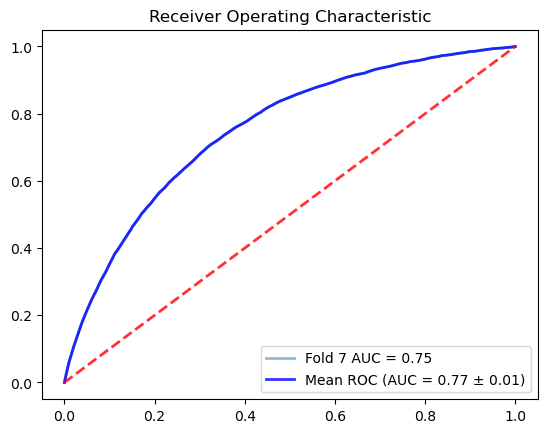

CV AUC scores:  [0.7692721764538448, 0.7715316067254401, 0.7714838341400583, 0.7708493604570098, 0.7701614851674293, 0.7527666618785761, 0.7527666618785761]
Maximum CV AUC score:  0.7715316067254401


In [170]:
from sklearn.metrics import roc_curve, auc as calculate_auc

tprs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

y_pred_proba = pipeline.predict_proba(X_valid_fold)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid_fold, y_pred_proba)
roc_auc = calculate_auc(fpr, tpr)
cv_scores.append(roc_auc)

# Interpolate the TPR (true positive rate) for the current fold
interp_tpr = np.interp(mean_fpr, fpr, tpr)
interp_tpr[0] = 0.0  # Set the first point in the interpolated TPR to zero
tprs.append(interp_tpr)

# Plot the ROC curve for the current fold
ax.plot(fpr, tpr, label=f'Fold {len(cv_scores)} AUC = {roc_auc:.2f}', lw=2, alpha=0.5)

# Compute the mean AUC and mean interpolated TPR
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Set the last point in the interpolated TPR to one
mean_auc = np.mean(cv_scores)
std_auc = np.std(cv_scores)

# Plot the mean ROC curve
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
        lw=2, alpha=0.8)

# Plot the chance line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# Customize the plot
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

# Output the cross-validation AUC scores
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))


In [28]:
df_smote_pre['target'].value_counts()

target
0    1478665
1      47994
Name: count, dtype: int64

target:
0: 1478665;
1: 47994
rate: 0.03245765606137969

In [76]:

logistic_params = {
    "random_state": 42,
    "max_iter": 10,
    "solver": 'liblinear'  # 对于小数据集或二分类问题，'liblinear'是个不错的选择
}

def model_c(df, strategy='median', classifier=LogisticRegression(**logistic_params)):
    simple_imputer = SimpleImputer(strategy=strategy)


    
    num_pipeline = Pipeline([
        ('imputer', simple_imputer),
    ])
    df_list = [col for col in df.columns]
    # 定义ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, df_list),  # 应用于数值型特征

        ])
    model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)])

    return model
def model_training(df, target, test_size = 0.05 , random_state=42, model=None , inputer_prams = "mean"):
    model = model(df, strategy='median', params=logistic_params)
    

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Initialize a list to hold the split datasets for validation
    validation_results = []
    
    # Perform the data splitting for validation
    for idx_train, idx_valid in cv.split(X_train, y_train):
        X_val_train, y_val_train = X_train.iloc[idx_train], y_train.iloc[idx_train]
        X_val_valid, y_val_valid = X_train.iloc[idx_valid], y_train.iloc[idx_valid]
        validation_results.append((X_val_train, y_val_train, X_val_valid, y_val_valid))

    return  X_val_train, y_val_train, X_val_valid, y_val_valid, X_test, y_test, validation_results

In [77]:


def cross_validate_model(X, y):
    df_list = [col for col in X.columns]
    # 定义过采样和模型训练的管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), df_list),
        ])
    
    # Defining the imbalanced-learn pipeline with oversampling and logistic regression
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', LogisticRegression())
    ])
    
    # 定义分层K折交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 计算交叉验证的分数
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    predicted = cross_val_predict(pipeline, X, y, cv=cv)

    # 计算混淆矩阵
    cm = confusion_matrix(y, predicted)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return scores



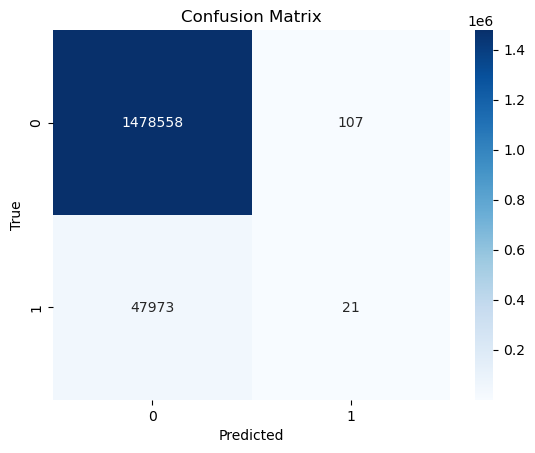

CV AUC scores raw_data 15 pre_bin: [0.96849004 0.96853589 0.96852279 0.96850641 0.96847683]
Average CV AUC score raw_data 15 pre_bin: 0.9685063920433059


In [78]:
# raw_data 15 pre_bin   
y = df_smote_woe['target']
df_smote_pre_bin = df_smote_pre.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_smote_pre_bin, y, test_size=0.1, random_state=66)
X_train

#
scores= cross_validate_model(df_smote_pre_bin, y)
print("CV AUC scores raw_data 15 pre_bin:", scores)
print("Average CV AUC score raw_data 15 pre_bin:", scores.mean())

In [84]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split,cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

def cross_validate_model_oversample(X, y):
    df_list = [col for col in X.columns]
    # 定义过采样和模型训练的管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), df_list),
        ])
    
    # Defining the imbalanced-learn pipeline with oversampling and logistic regression
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('oversample', RandomOverSampler(random_state=42)),
        ('classifier', LogisticRegression())
    ])
    
    # 定义分层K折交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = pipeline.fit(X, y)
    # 计算交叉验证的分数
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    predicted = cross_val_predict(pipeline, X, y, cv=cv)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y, predicted)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return scores, model

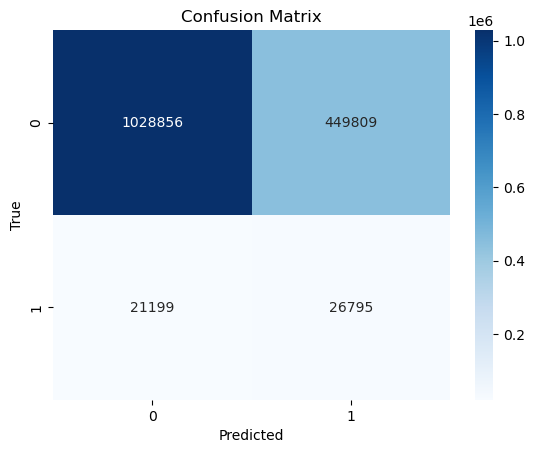

CV AUC scores raw_data 15 pre_bin with oversample: [0.68938401 0.69928799 0.68994734 0.68855213 0.69021816]
Average CV AUC score raw_data 15 pre_bin with oversample: 0.6914779258106958


In [80]:
# raw_data 15 pre_bin   
y = df_smote_woe['target']

df_smote_pre_bin = df_smote_pre.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_smote_pre_bin, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model_oversample(df_smote_pre_bin, y)
print("CV AUC scores raw_data 15 pre_bin with oversample:", scores)
print("Average CV AUC score raw_data 15 pre_bin with oversample:", scores.mean())

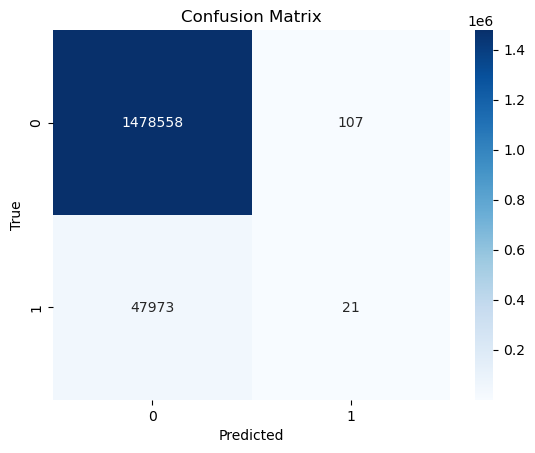

CV AUC scores raw_data 15 pre_bin with oversample: [0.96849004 0.96853589 0.96852279 0.96850641 0.96847683]
Average CV AUC score raw_data 15 pre_bin with oversample: 0.9685063920433059


In [81]:
df_smote_pre_bin = df_smote_pre.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_smote_pre_bin, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model(df_smote_pre_bin, y)
print("CV AUC scores raw_data 15 pre_bin with oversample:", scores)
print("Average CV AUC score raw_data 15 pre_bin with oversample:", scores.mean())

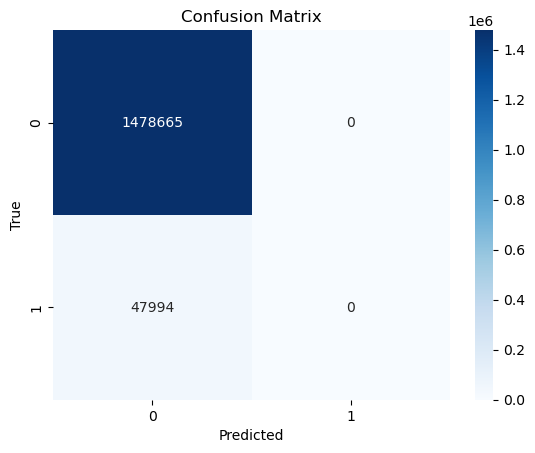

CV AUC scores df_smote_wsex_wOalter bin NO oversample: [0.96856209 0.96856209 0.96856209 0.96856209 0.96856526]
Average CV AUC score df_smote_wsex_wOalter bin NO oversample: 0.9685627242249499


In [105]:
df_2 = df_smote_wsex_wOalter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model(df_2, y)
print("CV AUC scores df_smote_wsex_wOalter bin NO oversample:", scores)
print("Average CV AUC score df_smote_wsex_wOalter bin NO oversample:", scores.mean())

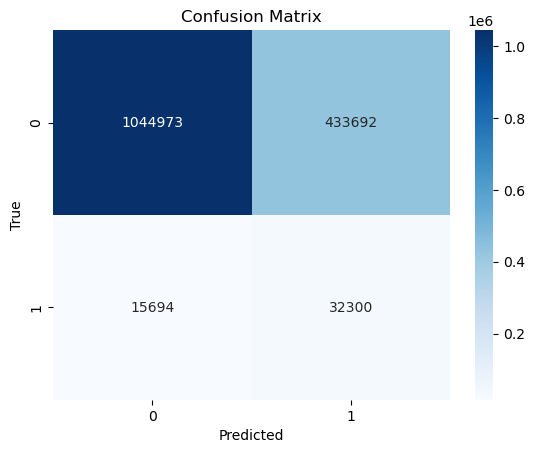

CV AUC scores df_smote_wsex_wOalter bin oversample: [0.70253691 0.70334259 0.70969961 0.70276944 0.70985586]
Average CV AUC score df_smote_wsex_wOalter bin oversample: 0.7056408826168639


In [103]:
df_2 = df_smote_wsex_wOalter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model_oversample(df_2, y)
print("CV AUC scores df_smote_wsex_wOalter bin oversample:", scores)
print("Average CV AUC score df_smote_wsex_wOalter bin oversample:", scores.mean())

df_smote_wOsex_wOalter = df_smote_woe[select_smote_wOsex_wOalter]
df_smote_wsex_walter = df_smote_woe
df_smote_wsex_wOalter = df_smote_woe.drop(columns=['mean_employedfrom_700D_woe', 'max_incometype_1044T_cnt_woe'])
df_smote_wOsex_walter = df_smote_woe.drop(columns=['max_sex_738L_woe'])

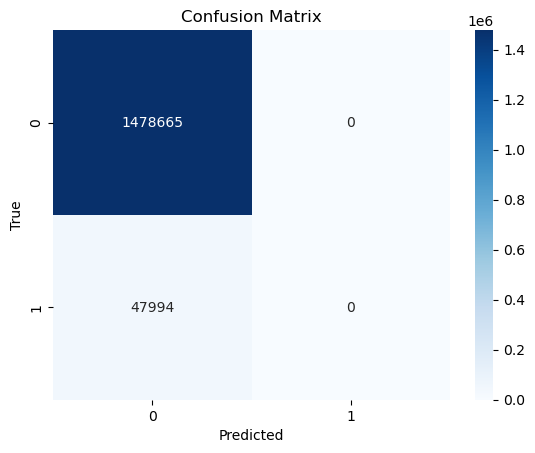

CV AUC scores df_smote_wOsex_wOalter bin NO oversample: [0.96856209 0.96856209 0.96856209 0.96856209 0.96856526]
Average CV AUC score df_smote_wOsex_wOalter bin NO oversample: 0.9685627242249499


In [108]:
df_2 = df_smote_wOsex_wOalter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model(df_2, y)
print("CV AUC scores df_smote_wOsex_wOalter bin NO oversample:", scores)
print("Average CV AUC score df_smote_wOsex_wOalter bin NO oversample:", scores.mean())

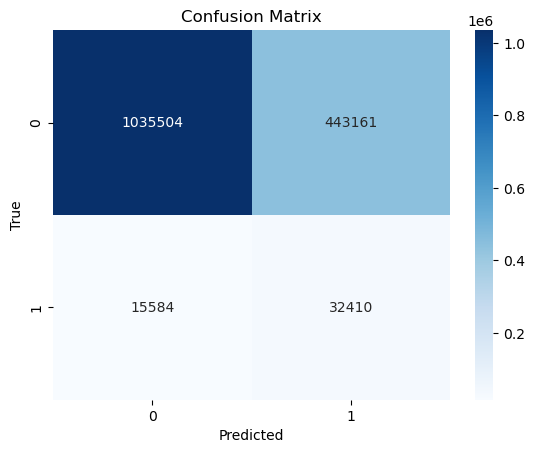

CV AUC scores df_smote_wOsex_wOalter bin oversample: [0.69908166 0.69955655 0.69945502 0.70009367 0.69936561]
Average CV AUC score df_smote_wOsex_wOalter bin oversample: 0.6995104996303082


In [106]:
df_2 = df_smote_wOsex_wOalter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model_oversample(df_2, y)
print("CV AUC scores df_smote_wOsex_wOalter bin oversample:", scores)
print("Average CV AUC score df_smote_wOsex_wOalter bin oversample:", scores.mean())

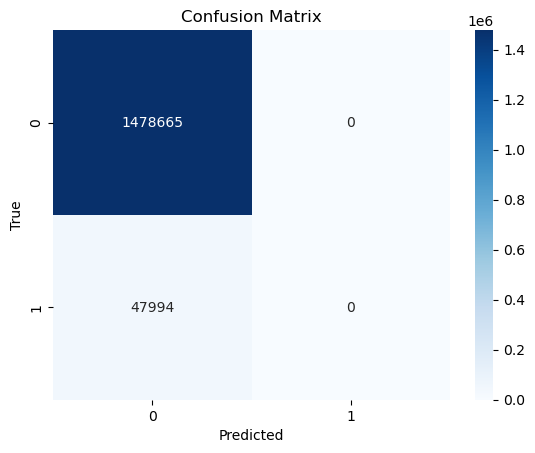

CV AUC scores df_smote_wsex_wOalter bin NO oversample: [0.96856209 0.96856209 0.96856209 0.96856209 0.96856526]
Average CV AUC score df_smote_wsex_wOalter bin NO oversample: 0.9685627242249499


In [82]:
df_2 = df_smote_wsex_wOalter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model(df_2, y)
print("CV AUC scores df_smote_wsex_wOalter bin NO oversample:", scores)
print("Average CV AUC score df_smote_wsex_wOalter bin NO oversample:", scores.mean())

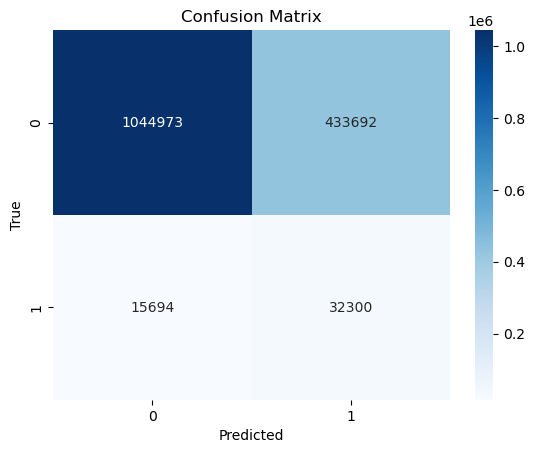

CV AUC scores df_smote_wsex_wOalter bin oversample: [0.70253691 0.70334259 0.70969961 0.70276944 0.70985586]
Average CV AUC score df_smote_wsex_wOalter bin oversample: 0.7056408826168639


In [83]:
df_2 = df_smote_wsex_wOalter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model_oversample(df_2, y)
print("CV AUC scores df_smote_wsex_wOalter bin oversample:", scores)
print("Average CV AUC score df_smote_wsex_wOalter bin oversample:", scores.mean())

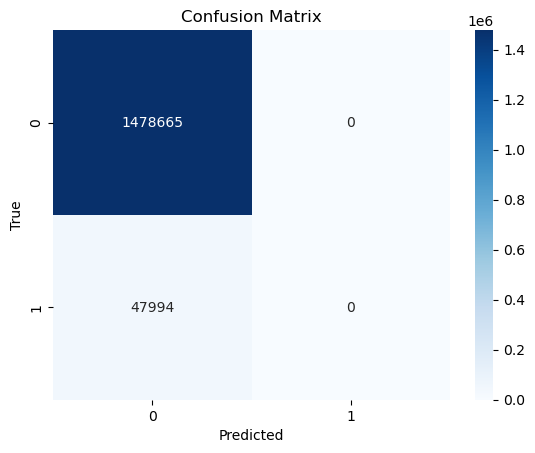

CV AUC scores df_smote_wOsex_walter bin NO oversample: [0.96856209 0.96856209 0.96856209 0.96856209 0.96856526]
Average CV AUC score df_smote_wOsex_walter bin NO oversample: 0.9685627242249499


In [111]:
df_2 = df_smote_wOsex_walter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores= cross_validate_model(df_2, y)
print("CV AUC scores df_smote_wOsex_walter bin NO oversample:", scores)
print("Average CV AUC score df_smote_wOsex_walter bin NO oversample:", scores.mean())

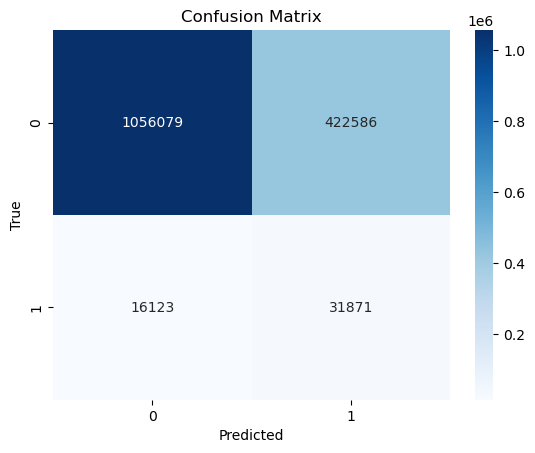

CV AUC scores df_smote_wOsex_walter bin oversample: [0.71179896 0.7134529  0.71236556 0.71308281 0.71247269]
Average CV AUC score df_smote_wOsex_walter bin oversample: 0.7126345829933931


In [85]:
df_2 = df_smote_wOsex_walter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)


#
scores, logistic_regression_model= cross_validate_model_oversample(df_2, y)
print("CV AUC scores df_smote_wOsex_walter bin oversample:", scores)
print("Average CV AUC score df_smote_wOsex_walter bin oversample:", scores.mean())

In [91]:
col_meow = X_train.columns
col_meow

Index(['max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe',
       'mean_pmts_overdue_1152A_woe', 'lastcancelreason_561M_cnt_woe',
       'max_birth_259D_woe', 'mean_employedfrom_700D_woe',
       'avgdpdtolclosure24_3658938P_woe', 'maxdpdlast24m_143P_woe',
       'mean_pmts_dpd_1073P_woe', 'pctinstlsallpaidlate1d_3546856L_woe',
       'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe',
       'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe'],
      dtype='object')

In [171]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe',
       'mean_pmts_overdue_1152A_woe', 'lastcancelreason_561M_cnt_woe',
       'max_birth_259D_woe', 'mean_employedfrom_700D_woe',
       'avgdpdtolclosure24_3658938P_woe', 'maxdpdlast24m_143P_woe',
       'mean_pmts_dpd_1073P_woe', 'pctinstlsallpaidlate1d_3546856L_woe',
       'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe',
       'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe'],
      dtype='object'))])),
                ('oversample', RandomOverSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [172]:
# 获取逻辑回归模型的系数
"""['max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe',
       'mean_pmts_overdue_1152A_woe', 'lastcancelreason_561M_cnt_woe',
       'max_birth_259D_woe', 'mean_employedfrom_700D_woe',
       'avgdpdtolclosure24_3658938P_woe', 'maxdpdlast24m_143P_woe',
       'mean_pmts_dpd_1073P_woe', 'pctinstlsallpaidlate1d_3546856L_woe',
       'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe',
       'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe']"""
logistic_model = pipeline.named_steps['classifier']
logistic_coefs = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# 打印系数和截距
print("Coefficients:", logistic_coefs)
print("Intercept:", intercept)

# 设置评分卡参数
base_score = 600  # 暂定600
PDO = 20  # 暂定20，可以修改
factor = PDO / np.log(2)
offset = base_score - factor * np.log(20)  # 暂定20

# 计算特征得分
feature_names = X_train.columns
scores = pd.Series(logistic_coefs, index=feature_names) * factor

Coefficients: [ 0.56158031  0.44531757  0.21116122  0.00734834  0.5676321   0.6494282
  0.3894144  -0.02433764  0.51397576  0.17210138  0.33077571  0.06613144
  0.2093988   0.66244939]
Intercept: -0.004089296939168167


In [175]:
feature_names = X_train.columns  # X_test 中的特征名称
scorecard = pd.DataFrame({'Feature': feature_names, 'Score': logistic_coefs * factor})
scorecard['Score'] = scorecard['Score'].round(0)  # 分数四舍五入到整数

# 计算截距对应的分数
intercept_score = offset + intercept * factor

# 将截距分数添加到 DataFrame 中
scorecard.loc[len(scorecard)] = ['Intercept', intercept_score]

# 计算新样本的信用评分，确保不将截距用于点乘
# 分离出截距外的评分
feature_scores = scorecard[scorecard['Feature'] != 'Intercept']['Score']

# 点乘 X_test 的特征和相应的分数
X_test['Score'] = np.dot(X_test[feature_names], feature_scores) + intercept_score


In [179]:
X_test['Score']

692809     507.388097
1002937    491.570984
235540     518.017552
989213     498.852732
239964     518.246109
              ...    
271496     491.142092
918060     493.138348
1412120    456.449349
1385490    489.763357
1328061    561.798251
Name: Score, Length: 152666, dtype: float64

In [181]:
from sklearn.metrics import f1_score

thresholds = np.linspace(start=min(X_test['Score']), stop=max(X_test['Score']), num=100)
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    # 根据阈值预测新样本是否为好客户（'0'表示好，'1'表示坏）
    X_test['Predicted'] = X_test['Score'].apply(lambda x: 0 if x >= threshold else 1)
    f1 = f1_score(y_test, X_test['Predicted'], pos_label=1)  # 确保违约类别标记为1
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'最佳阈值: {best_threshold}, 最佳F1得分: {best_f1}')


最佳阈值: 602.1666262156573, 最佳F1得分: 0.06106637539055554


In [178]:
thresholds = np.linspace(start=min(X_test['Score']), stop=max(X_test['Score']), num=100)
thresholds

array([436.84525196, 438.54959603, 440.25394009, 441.95828416,
       443.66262822, 445.36697228, 447.07131635, 448.77566041,
       450.48000448, 452.18434854, 453.88869261, 455.59303667,
       457.29738074, 459.0017248 , 460.70606886, 462.41041293,
       464.11475699, 465.81910106, 467.52344512, 469.22778919,
       470.93213325, 472.63647732, 474.34082138, 476.04516544,
       477.74950951, 479.45385357, 481.15819764, 482.8625417 ,
       484.56688577, 486.27122983, 487.9755739 , 489.67991796,
       491.38426202, 493.08860609, 494.79295015, 496.49729422,
       498.20163828, 499.90598235, 501.61032641, 503.31467048,
       505.01901454, 506.72335861, 508.42770267, 510.13204673,
       511.8363908 , 513.54073486, 515.24507893, 516.94942299,
       518.65376706, 520.35811112, 522.06245519, 523.76679925,
       525.47114331, 527.17548738, 528.87983144, 530.58417551,
       532.28851957, 533.99286364, 535.6972077 , 537.40155177,
       539.10589583, 540.81023989, 542.51458396, 544.21

In [95]:
# 打印评分卡
print(scorecard)

                                  Feature       Score
0            max_incometype_1044T_cnt_woe   16.000000
1                  mean_pmts_dpd_303P_woe   13.000000
2             mean_pmts_overdue_1152A_woe    6.000000
3           lastcancelreason_561M_cnt_woe    0.000000
4                      max_birth_259D_woe   16.000000
5              mean_employedfrom_700D_woe   19.000000
6         avgdpdtolclosure24_3658938P_woe   11.000000
7                  maxdpdlast24m_143P_woe   -1.000000
8                 mean_pmts_dpd_1073P_woe   15.000000
9     pctinstlsallpaidlate1d_3546856L_woe    5.000000
10       maxdbddpdtollast12m_3658940P_woe   10.000000
11          lastrejectreason_759M_cnt_woe    2.000000
12  max_numberofoverdueinstlmax_1039L_woe    6.000000
13                 lastrejectdate_50D_woe   19.000000
14                              Intercept  513.443446


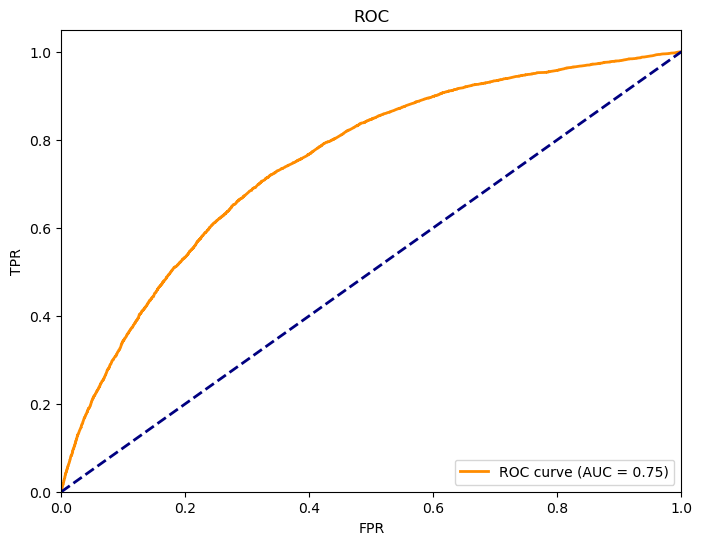

In [121]:
# 计算 ROC 曲线和 AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, X_test['Score'], pos_label=1)  # pos_label=0 指定好客户标签为0
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [97]:
# 计算 K-S 统计量
ks = max(tpr - fpr)
print(f'K-S 统计量: {ks:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

K-S 统计量: 0.000
ROC AUC: 0.251


In [89]:
X_test
y_test

692809     0
1002937    0
235540     0
989213     0
239964     0
          ..
271496     0
918060     0
1412120    0
1385490    0
1328061    0
Name: target, Length: 152666, dtype: int8

In [113]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

def cross_validate_model(X, y):
    df_list = [col for col in X.columns]
    # 定义过采样和模型训练的管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), df_list),
        ])
    logistic_params = {
    "random_state": 42,
    "max_iter": 20,
    "solver": 'liblinear' 
}
    # Defining the imbalanced-learn pipeline with oversampling and logistic regression
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        
        ('classifier', LogisticRegression(**logistic_params))
    ])
    
    # 定义分层K折交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 计算交叉验证的分数
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    predicted = cross_val_predict(pipeline, X, y, cv=cv)

    # 计算混淆矩阵
    cm = confusion_matrix(y, predicted)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return scores



In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

def cross_validate_random_forest(X, y, rf_params, n_splits=5, random_state=42):
    # Initialize StratifiedKFold
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = []
    fitted_models = []
    df_list = [col for col in X.columns]
    
    # Loop through each fold
    for idx_train, idx_valid in cv.split(X, y):
        X_train, X_valid = X.iloc[idx_train], X.iloc[idx_valid]
        y_train, y_valid = y.iloc[idx_train], y.iloc[idx_valid]

        # Create RandomForest model
        model = RandomForestClassifier(**rf_params)
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred_valid = model.predict_proba(X_valid)[:, 1]  # Assuming binary classification
        
        # Compute AUC score
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores.append(auc_score)
        
        # Store the fitted model
        fitted_models.append(model)
    
    return cv_scores, fitted_models

# Example usage:
# Assuming df_features and df_target are your feature and target datasets
# rf_params as defined above


In [116]:
rf_params = {
    "n_estimators": 2000,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    #"max_features": 'auto',  # 相当于 colsample_bytree
    "bootstrap": True,  # 使用放回抽样
    "random_state": 42,
    "n_jobs": -1  # 使用所有可用的CPU核心
}

In [118]:
df_2 = df_smote_wOsex_walter.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(
        df_2, y, test_size=0.1, random_state=66)



scores, models = cross_validate_random_forest(df_2, y, rf_params)
print("Cross-Validation AUC Scores df_smote_wOsex_walter :", scores)
print("Average AUC Score df_smote_wOsex_walter :", np.mean(scores))

Cross-Validation AUC Scores df_smote_wOsex_walter : [0.765779191089569, 0.7692351308066661, 0.767367502560599, 0.7666313195306305, 0.7661165349749872]
Average AUC Score df_smote_wOsex_walter : 0.7670259357924903


In [122]:
from sklearn.metrics import roc_auc_score, classification_report
def ensemble_predictions(models, X_test):
    """
    Aggregate predictions from multiple models and compute the ensemble prediction.
    
    Parameters:
    - models: List of trained RandomForest models.
    - X_test: Test feature set.
    
    Returns:
    - ensemble_pred_proba: The average predicted probabilities from all models.
    """
    # Aggregate predictions from each model
    predictions = [model.predict_proba(X_test)[:, 1] for model in models]
    ensemble_pred_proba = np.mean(predictions, axis=0)
    return ensemble_pred_proba

# Compute ensemble predictions and evaluate them
if models:
    ensemble_pred_proba = ensemble_predictions(models, X_test)
    ensemble_auc_score = roc_auc_score(y_test, ensemble_pred_proba)
    print("Ensemble AUC rf Score:", ensemble_auc_score)
else:
    print("No models are available for evaluation.")


Ensemble AUC rf Score: 0.772330971688918


Confusion Matrix:
[[147858      0]
 [  4808      0]]


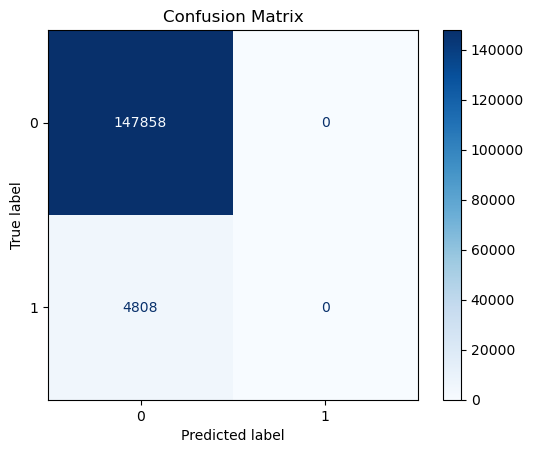

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    147858
           1       0.00      0.00      0.00      4808

    accuracy                           0.97    152666
   macro avg       0.48      0.50      0.49    152666
weighted avg       0.94      0.97      0.95    152666



In [128]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def ensemble_predictions(models, X_test):
    # Collect predictions from each model
    predictions = [model.predict_proba(X_test)[:, 1] for model in models]
    # Average the predictions
    mean_predictions = np.mean(predictions, axis=0)
    # Convert probabilities to class labels based on a threshold of 0.5
    return (mean_predictions > 0.5).astype(int)

def evaluate_model_with_confusion_matrix(models, X_test, y_test):

    if not models:
        print("No models are available for evaluation.")
        return

    # Predict class labels for the test set using ensemble
    y_pred = ensemble_predictions(models, X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Display the confusion matrix using matplotlib (optional)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Print a classification report for additional metrics
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Assuming 'models' contains a list of trained models
evaluate_model_with_confusion_matrix(models, X_test, y_test)


In [120]:
X_test

mean_employedfrom_700D_woe  maxdbddpdtollast12m_3658940P_woe  \
692809                     0.515950                         -0.456451   
1002937                   -0.200550                         -0.456451   
235540                    -0.200550                         -0.031277   
989213                     0.175677                         -0.456451   
239964                    -0.200550                         -0.031277   
...                             ...                               ...   
271496                    -0.574062                         -0.031277   
918060                    -0.127824                         -0.456451   
1412120                   -0.574062                         -0.456451   
1385490                   -0.127824                         -0.031277   
1328061                   -0.574062                          0.958101   

         mean_pmts_dpd_1073P_woe  lastcancelreason_561M_cnt_woe  \
692809                  0.057902                      -0.257678   
1002937                -0.444969                       0.581545   
235540                  0.803228                      -0.257678   
989213                 -0.444969                      -0.257678   
239964                  0.803228                      -0.257678   
...                          ...                            ...   
271496                 -0.444969                      -0.257678   
918060                 -0.444969                      -0.257678   
1412120                -0.444969                       0.089704   
1385490                -0.444969                       0.581545   
1328061                 0.803228                      -0.257678   

         max_incometype_1044T_cnt_woe  maxdpdlast24m_143P_woe  \
692809                       0.222649               -0.177920   
1002937                      0.222649               -0.177920   
235540                       0.222649               -0.370821   
989213                       0.158360               -0.177920   
239964                       0.222649               -0.370821   
...                               ...                     ...   
271496                       0.158360               -0.177920   
918060                      -0.556503               -0.177920   
1412120                     -0.556503               -0.177920   
1385490                     -0.556503               -0.177920   
1328061                     -0.133298                1.047332   

         avgdpdtolclosure24_3658938P_woe  lastrejectdate_50D_woe  \
692809                         -0.496113               -0.410967   
1002937                        -0.496113                0.727378   
235540                         -0.065876               -0.410967   
989213                         -0.496113                0.476607   
239964                         -0.065876               -0.410967   
...                                  ...                     ...   
271496                         -0.065876               -0.176262   
918060                         -0.496113               -0.176262   
1412120                        -0.496113                0.476607   
1385490                         0.372260                0.182380   
1328061                         1.144349                0.182380   

         pctinstlsallpaidlate1d_3546856L_woe  mean_pmts_dpd_303P_woe  \
692809                             -0.609562               -0.001084   
1002937                            -0.609562               -0.759893   
235540                             -0.075837               -0.001084   
989213                             -0.080544               -0.759893   
239964                             -0.075837               -0.001084   
...                                      ...                     ...   
271496                             -0.075837               -0.001084   
918060                              0.420679                0.670125   
1412120                            -0.609562               -0.759893   
1385490  

lgb and exp


In [114]:
weeks = df_train["WEEK_NUM"]
X = df_train
y = df_train['target']
X = X.drop(columns=["target", "case_id", "WEEK_NUM"])


month_decision  weekday_decision  credamount_770A  \
0                     1                 4     30000.000000   
1                     1                 4     19999.800781   
2                     1                 5     78000.000000   
3                     1                 4     40000.000000   
4                     1                 5     44000.000000   
...                 ...               ...              ...   
1526654              10                 1     30000.000000   
1526655              10                 1    100000.000000   
1526656              10                 1     60000.000000   
1526657              10                 1      6000.000000   
1526658              10                 1     39414.000000   

         applicationcnt_361L  applications30d_658L  applicationscnt_1086L  \
0                        0.0                   0.0                    0.0   
1                        0.0                   0.0                    0.0   
2                        0.0                   0.0                    0.0   
3                        0.0                   1.0                    0.0   
4                        0.0                   1.0                    0.0   
...                      ...                   ...                    ...   
1526654                  0.0                   0.0                    0.0   
1526655                  0.0                   0.0                    5.0   
1526656                  0.0                   0.0                    0.0   
1526657                  0.0                   0.0                   36.0   
1526658                  0.0                   0.0                    0.0   

         applicationscnt_464L  applicationscnt_867L  clientscnt_1022L  \
0                         0.0                   0.0               0.0   
1                         0.0                   0.0               0.0   
2                         0.0                   0.0               0.0   
3                         2.0                   1.0               0.0   
4                         0.0                   1.0               0.0   
...                       ...                   ...               ...   
1526654                   0.0                  10.0               0.0   
1526655                   0.0                   5.0               0.0   
1526656                   0.0                   3.0               0.0   
1526657                   0.0                   9.0               1.0   
1526658                   0.0                   0.0               0.0   

         clientscnt_100L  ...  max_cacccardblochreas_147M  \
0                    0.0  ...                         NaN   
1                    0.0  ...                         NaN   
2                    0.0  ...                         NaN   
3                    0.0  ...                         NaN   
4                    0.0  ...                         NaN   
...                  ...  ...                         ...   
1526654              0.0  ...                    a55475b1   
1526655              0.0  ...                    a55475b1   
1526656              0.0  ...                    a55475b1   
1526657              0.0  ...                    a55475b1   
1526658              0.0  ...                    a55475b1   

         last_cacccardblochreas_147M  max_conts_type_509L  \
0                                NaN                  NaN   
1                                NaN                  NaN   
2                                NaN       PRIMARY_MOBILE   
3                                NaN       PRIMARY_MOBILE   
4                                NaN       PRIMARY_MOBILE   
...                              ...                  ...   
1526654                     a55475b1       PRIMARY_MOBILE   
1526655                     a55475b1       PRIMARY_MOBILE   
1526656                     a55475b1       PRIMARY_MOBILE   
1526657                     a55475b1       PRIMARY_MOBILE   
1526658                     a55475b1       PRIMARY_MOBILE 

In [135]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
#CV AUC scores:  [0.8371927975406236, 0.830791286059915, 0.8336734561908583, 0.8387841657287671, 0.8336706030116027]
#Maximum CV AUC score:  0.8387841657287671
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 300,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64, 
    "verbose": -1,
}

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(X, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(50)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

    
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.846084
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.849226
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.846931
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.8497
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.851555
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.854376
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.851139
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.85404
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.847203
Did not meet early stopping. Best iteration is:
[300]	valid_0's auc: 0.850585
CV AUC scores:  [0.8492257526528729, 0.8496997708287967, 0.8543760967743024, 0.8540398921729143, 0.850584597459638]
Maximum CV AUC score:  0.8543760967743024


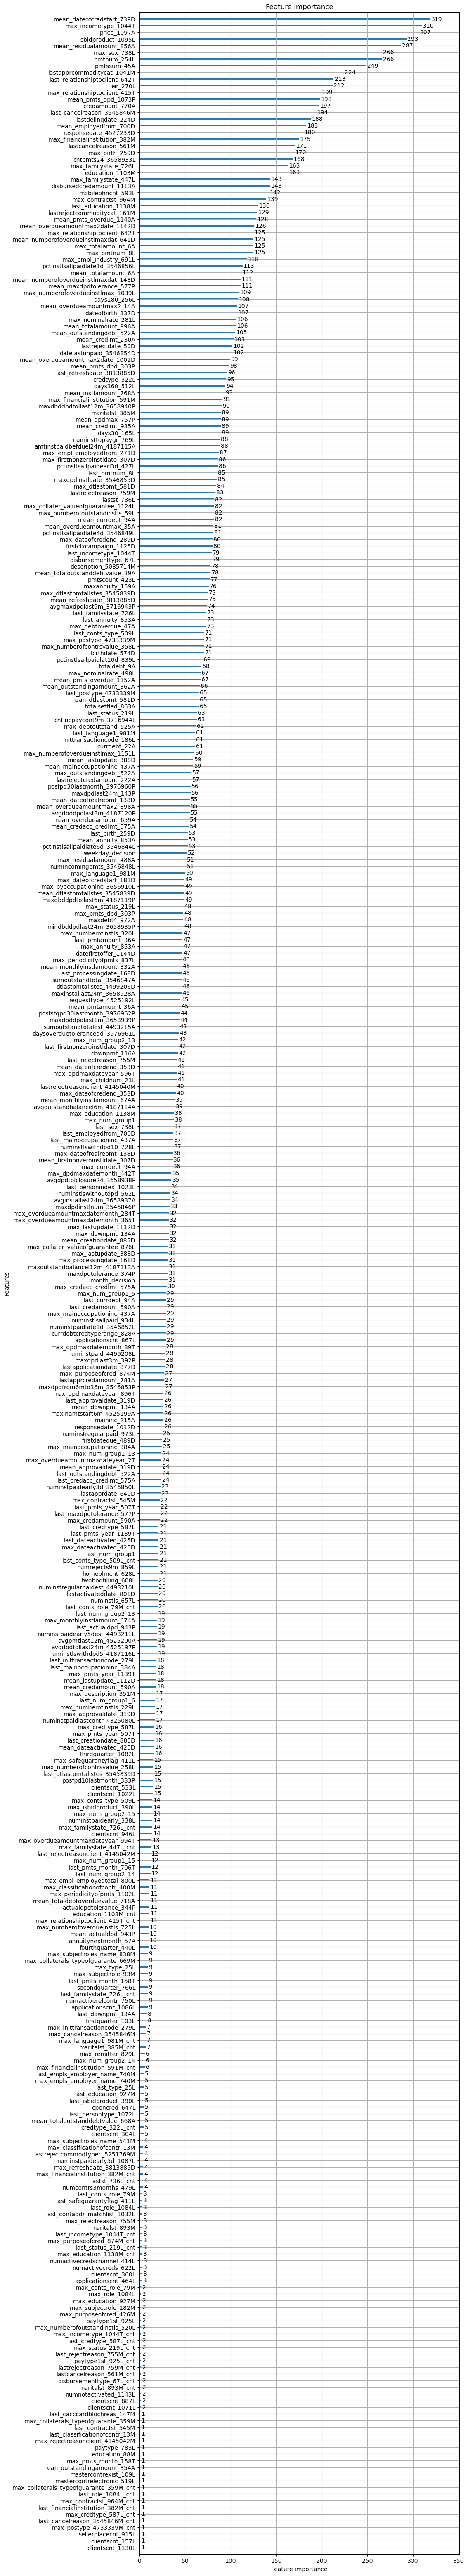

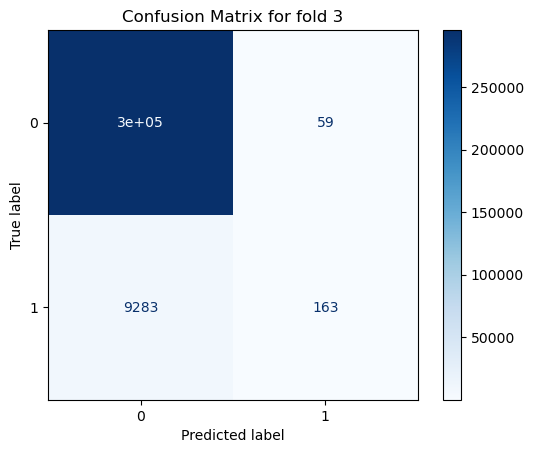

In [138]:
model3 = fitted_models[2]

# Ensure you have the validation set used during the training of this model
# You might need to store `X_valid` and `y_valid` during each fold iteration
# For the purpose of this example, let's assume X_valid and y_valid are known for the third fold
# You must capture X_valid and y_valid during your cross-validation loop for this to work correctly

# Plot feature importances
lgb.plot_importance(model3, importance_type="split", figsize=(10, 80))
plt.show()

# Generate predictions - ensure to use the correct corresponding X_valid from the third fold
y_pred_labels = model3.predict(X_valid)  # Use predict() for class labels directly

# Generate confusion matrix
cm = confusion_matrix(y_valid, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for fold 3')
plt.show()

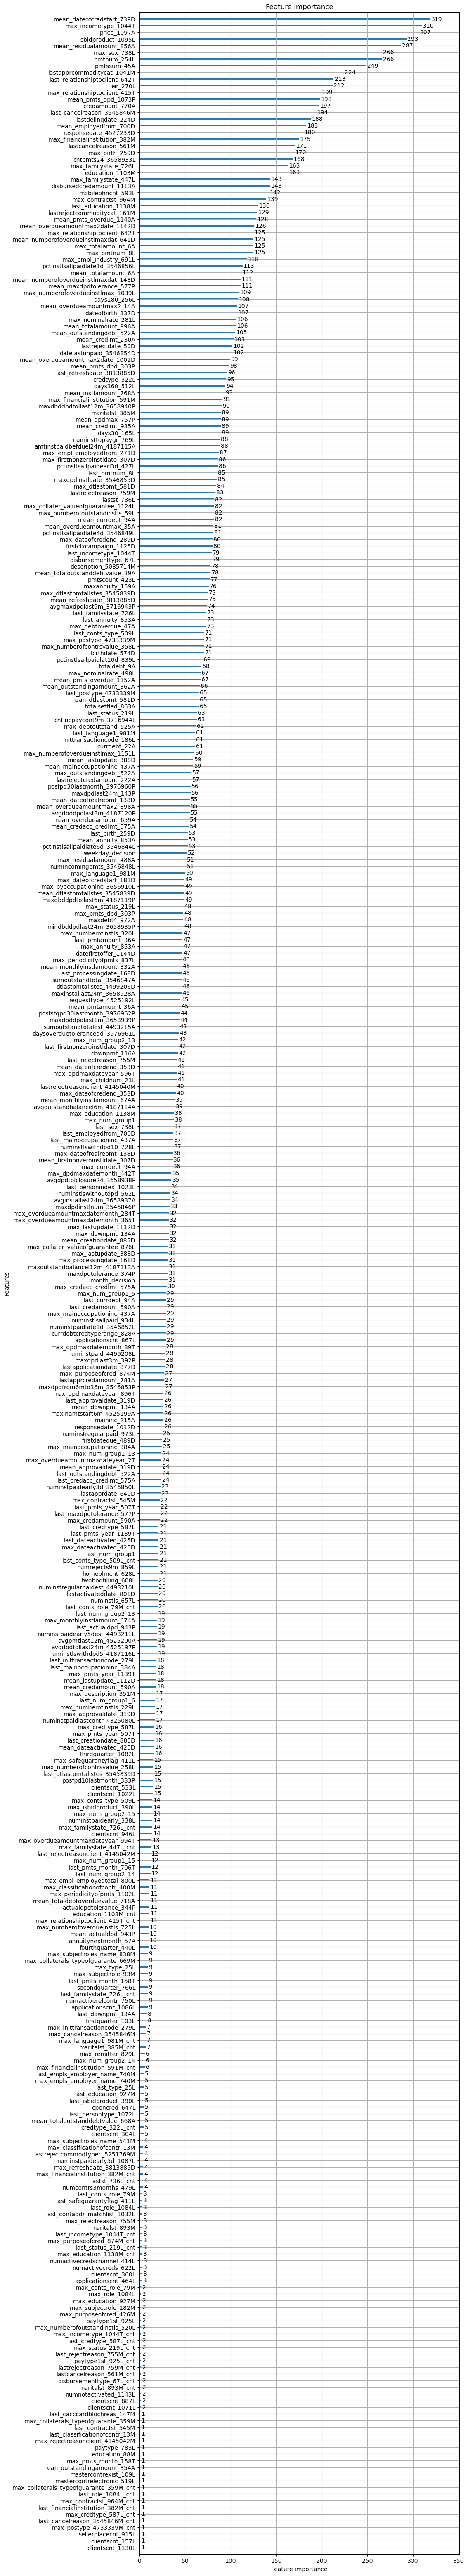

In [136]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,80))
plt.show()

In [182]:
#light gbm light
X = df_smote_wOsex_walter
y = df_smote_wOsex_walter['target']
X = X.drop(columns=['target'])
fitted_models = []
cv_scores = []
for idx_train, idx_valid in cv.split(X, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
        
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 38395, number of negative: 1182932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 1221327, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031437 -> initscore=-3.427824
[LightGBM] [Info] Start training from score -3.427824
Training until validation scores don't improve for

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


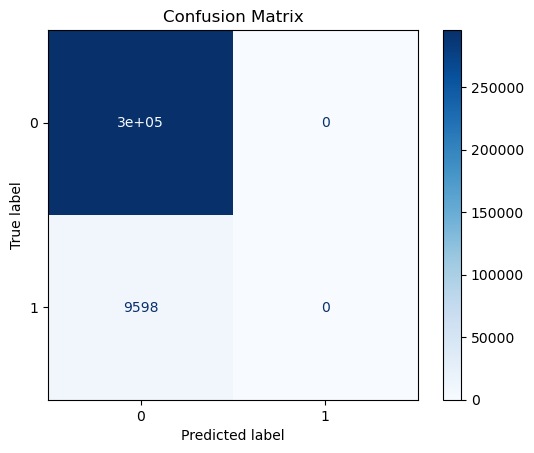

In [184]:
y_pred_labels = fitted_models[2].predict(X_valid)  # Use predict() for class labels directly

# Generate confusion matrix
cm = confusion_matrix(y_valid, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


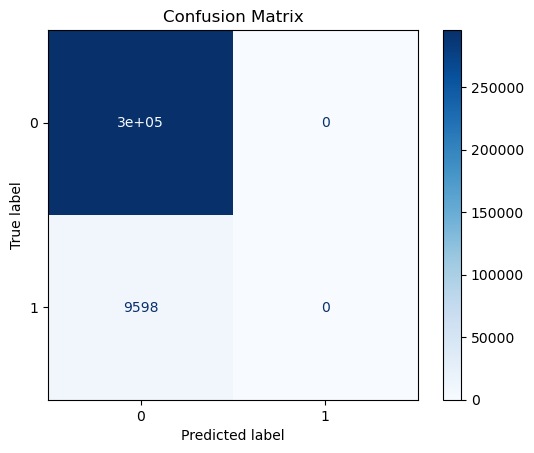

In [153]:
y_pred_labels = fitted_models[3].predict(X_valid)  # Use predict() for class labels directly

# Generate confusion matrix
cm = confusion_matrix(y_valid, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [185]:
X = df_smote_wOsex_walter
y = df_smote_wOsex_walter['target']
X = X.drop(columns=['target'])


# LightGBM parameters, ensure they are defined or define them here
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "max_depth": 10,
    "n_estimators":5000,
    "random_state": 42,
    # add more parameters as needed
}

fitted_models = []
cv_scores = []

# Setup the cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ros = RandomOverSampler(random_state=42)

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Apply oversampling only to the training data
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Create and fit the LightGBM model
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train_res, y_train_res,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(200), lgb.early_stopping(100)],
    )
    fitted_models.append(model)
    
    # Predict and evaluate
    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1182932, number of negative: 1182932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 2365864, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.769242
Early stopp

In [191]:
X = df_smote_wOsex_walter
y = df_smote_wOsex_walter['target']
X = X.drop(columns=['target'])
model = lgb.LGBMClassifier(**params)
lgb_clf = model.fit(X, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 47994, number of negative: 1478665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 1526659, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031437 -> initscore=-3.427819
[LightGBM] [Info] Start training from score -3.427819


In [197]:
X_test = X_test.drop(columns=['Predicted', 'Score'])

In [198]:
#xai
import shap
# 显示特征重要性
# 计算 SHAP 值
lgb_clf
explainer = shap.TreeExplainer(lgb_clf)
shap_values = explainer.shap_values(X_test)  # 假设 X_test 是模型测试集的特征数据

# 可视化第一个预测的 SHAP 值
shap.initjs()  # 初始化 JS 可视化环境



IndexError: invalid index to scalar variable.

In [201]:
shap_values

array([[ 0.21701661,  0.12576461,  0.04248311, ..., -0.06350966,
        -0.11431577, -0.15279201],
       [ 0.48298873, -0.25341768, -0.14394167, ...,  0.15714007,
         0.03910768,  0.70323191],
       [ 0.31115402,  0.11516553,  0.08168743, ..., -0.06009179,
         0.03756338, -0.12560354],
       ...,
       [-0.50006504, -0.17197337, -0.04259992, ..., -0.29696265,
         0.05686839, -0.2374848 ],
       [-0.60743288,  0.05260139,  0.07869968, ..., -0.16099204,
         0.01601453,  0.06360076],
       [-0.18526561,  0.47033534,  0.34583519, ...,  0.10776295,
         0.25131633,  0.01556342]])

In [214]:
smote_bins['avgdpdtolclosure24_3658938P']

variable         bin   count  count_distr    good  \
0  avgdpdtolclosure24_3658938P     missing  467175     0.306011  453397   
1  avgdpdtolclosure24_3658938P  [-inf,1.0)  763665     0.500220  748865   
2  avgdpdtolclosure24_3658938P   [1.0,3.0)  167237     0.109544  159715   
3  avgdpdtolclosure24_3658938P   [3.0,inf)  128582     0.084224  116688   

     bad   badprob       woe    bin_iv  total_iv   breaks  is_special_values  
0  13778  0.029492 -0.065876  0.001288   0.31098  missing               True  
1  14800  0.019380 -0.496113  0.098267   0.31098      1.0              False  
2   7522  0.044978  0.372260  0.018135   0.31098      3.0              False  
3  11894  0.092501  1.144349  0.193290   0.31098      inf              False

In [211]:
shap_values[1, :]


array([ 0.48298873, -0.25341768, -0.14394167, -0.06425156,  0.05455165,
        0.19322348,  0.02166574,  0.26083736, -0.19513475, -0.02786261,
       -0.06344979,  0.15714007,  0.03910768,  0.70323191])

In [212]:
X_test.columns

Index(['max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe',
       'mean_pmts_overdue_1152A_woe', 'lastcancelreason_561M_cnt_woe',
       'max_birth_259D_woe', 'mean_employedfrom_700D_woe',
       'avgdpdtolclosure24_3658938P_woe', 'maxdpdlast24m_143P_woe',
       'mean_pmts_dpd_1073P_woe', 'pctinstlsallpaidlate1d_3546856L_woe',
       'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe',
       'max_numberofoverdueinstlmax_1039L_woe', 'lastrejectdate_50D_woe'],
      dtype='object')

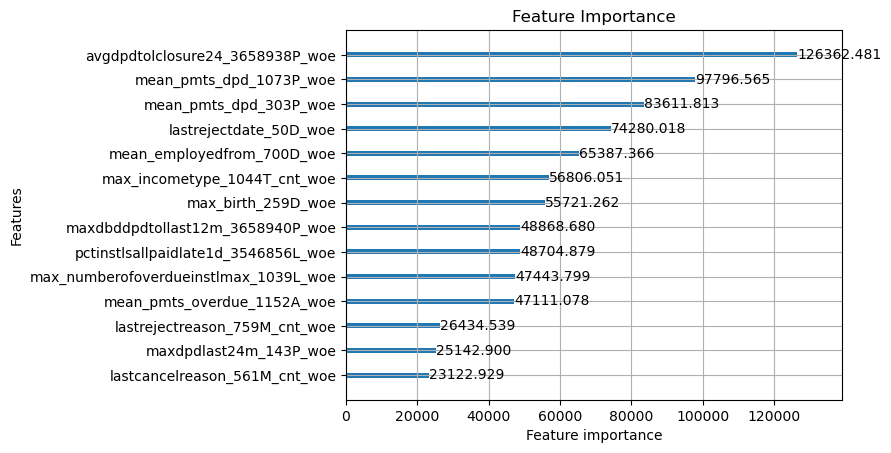

In [208]:
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[0, :], link="logit")
lgb.plot_importance(lgb_clf, max_num_features=30, importance_type='gain')
plt.title('Feature Importance')
plt.show()

In [218]:
merge_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
filtered_merge_test = merge_test[merge_test['target'] == 1]

In [224]:
merge_test

max_incometype_1044T_cnt_woe  mean_pmts_dpd_303P_woe  \
692809                       0.222649               -0.001084   
1002937                      0.222649               -0.759893   
235540                       0.222649               -0.001084   
989213                       0.158360               -0.759893   
239964                       0.222649               -0.001084   
...                               ...                     ...   
271496                       0.158360               -0.001084   
918060                      -0.556503                0.670125   
1412120                     -0.556503               -0.759893   
1385490                     -0.556503               -0.001084   
1328061                     -0.133298                0.670125   

         mean_pmts_overdue_1152A_woe  lastcancelreason_561M_cnt_woe  \
692809                     -0.001109                      -0.257678   
1002937                    -0.782143                       0.581545   
235540                     -0.001109                      -0.257678   
989213                     -0.235204                      -0.257678   
239964                     -0.001109                      -0.257678   
...                              ...                            ...   
271496                     -0.001109                      -0.257678   
918060                      0.632170                      -0.257678   
1412120                    -0.782143                       0.089704   
1385490                    -0.001109                       0.581545   
1328061                     0.632170                      -0.257678   

         max_birth_259D_woe  mean_employedfrom_700D_woe  \
692809             0.050180                    0.515950   
1002937            0.050180                   -0.200550   
235540             0.050180                   -0.200550   
989213             0.050180                    0.175677   
239964            -0.191411                   -0.200550   
...                     ...                         ...   
271496             0.050180                   -0.574062   
918060            -0.540805                   -0.127824   
1412120           -0.540805                   -0.574062   
1385490           -0.540805                   -0.127824   
1328061            0.050180                   -0.574062   

         avgdpdtolclosure24_3658938P_woe  maxdpdlast24m_143P_woe  \
692809                         -0.496113               -0.177920   
1002937                        -0.496113               -0.177920   
235540                         -0.065876               -0.370821   
989213                         -0.496113               -0.177920   
239964                         -0.065876               -0.370821   
...                                  ...                     ...   
271496                         -0.065876               -0.177920   
918060                         -0.496113               -0.177920   
1412120                        -0.496113               -0.177920   
1385490                         0.372260               -0.177920   
1328061                         1.144349                1.047332   

         mean_pmts_dpd_1073P_woe  pctinstlsallpaidlate1d_3546856L_woe  \
692809                  0.057902                            -0.609562   
1002937                -0.444969                            -0.609562   
235540                  0.803228                            -0.075837   
989213                 -0.444969                            -0.080544   
239964                  0.803228                            -0.075837   
...                          ...                                  ...   
271496                 -0.444969                            -0.075837   
918060                 -0.444969                             0.420679   
1412120                -0.444969                            -0.609562   
1385490                -0.444969                            -0.609562   
1328061                 0.803228              

In [220]:
import dice_ml
from dice_ml.utils import helpers  # Make sure you've installed dice_ml and it includes helpers



In [230]:
# Assuming lgb_clf is your trained LightGBM classifier model
# List of continuous features
continuous_features = [
    'max_incometype_1044T_cnt_woe', 'mean_pmts_dpd_303P_woe', 'mean_pmts_overdue_1152A_woe',
    'lastcancelreason_561M_cnt_woe', 'max_birth_259D_woe', 'avgdpdtolclosure24_3658938P_woe',
    'maxdpdlast24m_143P_woe', 'mean_pmts_dpd_1073P_woe', 'pctinstlsallpaidlate1d_3546856L_woe',
    'maxdbddpdtollast12m_3658940P_woe', 'lastrejectreason_759M_cnt_woe', 'max_numberofoverdueinstlmax_1039L_woe',
    'mean_employedfrom_700D_woe', 'lastrejectdate_50D_woe'
]

# Validate features in DataFrame
missing_cols = [col for col in continuous_features if col not in merge_test.columns]
if missing_cols:
    print("Missing columns in DataFrame:", missing_cols)
else:
    print("All specified features are present in the DataFrame.")

# Setup DiCE Data and Model
d = dice_ml.Data(dataframe=merge_test, continuous_features=continuous_features, outcome_name='target')
m = dice_ml.Model(model=lgb_clf, backend="sklearn")

# Create DiCE explainer
explainer = dice_ml.Dice(d, m)

# Select a particular instance to explain
user_select_idx = 12
desired_class = 1
# Generate counterfactual explanations
e1 = explainer.generate_counterfactuals(X_test[user_select_idx:user_select_idx+1], 
                                        total_CFs=10, 
                                        desired_class=desired_class)  # Ensure desired_class matches your model's expected input

# Visualize the counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=False)  # If you want to see only changes, set to True

All specified features are present in the DataFrame.


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

100%|██████████| 1/1 [00:07<00:00,  7.17s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

max_incometype_1044T_cnt_woe  mean_pmts_dpd_303P_woe  \
0                      0.222649                0.670125   

   mean_pmts_overdue_1152A_woe  lastcancelreason_561M_cnt_woe  \
0                      0.63217                       0.089704   

   max_birth_259D_woe  mean_employedfrom_700D_woe  \
0            0.488725                    0.175677   

   avgdpdtolclosure24_3658938P_woe  maxdpdlast24m_143P_woe  \
0                        -0.496113                1.047332   

   mean_pmts_dpd_1073P_woe  pctinstlsallpaidlate1d_3546856L_woe  \
0                -0.444969                            -0.080544   

   maxdbddpdtollast12m_3658940P_woe  lastrejectreason_759M_cnt_woe  \
0                          0.061209                       0.308867   

   max_numberofoverdueinstlmax_1039L_woe  lastrejectdate_50D_woe  target  
0                              -0.454595                 0.18238       0


Diverse Counterfactual set (new outcome: 1)


max_incometype_1044T_cnt_woe  mean_pmts_dpd_303P_woe  \
0                      0.222649                0.670125   
1                      0.222649                0.670125   
2                      0.222649                0.670125   
3                      0.222649                0.670125   
4                      0.222649                0.670125   
5                      0.222649                0.670125   
6                      0.222649                0.670125   
7                      0.222649                0.670125   
8                      0.222649                0.670125   
9                      0.222649                0.670125   

   mean_pmts_overdue_1152A_woe  lastcancelreason_561M_cnt_woe  \
0                     0.632170                       0.089704   
1                     0.632170                       0.089704   
2                     0.632170                       0.089704   
3                     0.632170                       0.089704   
4                     0.632170                       0.089704   
5                     0.632170                       0.089704   
6                     0.632170                       0.089704   
7                     0.070365                       0.089704   
8                     0.632170                       0.089704   
9                     0.632170                       0.089704   

   max_birth_259D_woe  mean_employedfrom_700D_woe  \
0            0.488725                    0.175677   
1            0.488725                    0.175677   
2            0.488725                    0.175677   
3            0.488725                    0.175677   
4            0.488725                    0.175677   
5            0.488725                    0.175677   
6            0.488725                    0.175677   
7            0.488725                    0.175677   
8            0.488725                    0.175677   
9            0.488725                    0.175677   

   avgdpdtolclosure24_3658938P_woe  maxdpdlast24m_143P_woe  \
0                        -0.496113                1.047332   
1                        -0.496113                1.047332   
2                        -0.496113                1.047332   
3                        -0.496113                1.047332   
4                        -0.496113                1.047332   
5                        -0.496113                1.047332   
6                        -0.496113                1.045398   
7                        -0.496113                1.047332   
8                        -0.496113                1.047332   
9                        -0.496113                1.047332   

   mean_pmts_dpd_1073P_woe  pctinstlsallpaidlate1d_3546856L_woe  \
0                 0.551321                            -0.080544   
1                 0.505422                            -0.080544   
2                 0.794568                            -0.080544   
3                 0.564728                            -0.080544   
4                 0.510189                            -0.080544   
5                 0.555934                            -0.080544   
6                 0.570678                            -0.080544   
7                 0.497279                            -0.080544   
8                 0.471342                            -0.080544   
9                 0.564119                            -0.080544   

   maxdbddpdtollast12m_3658940P_woe  lastrejectreason_759M_cnt_woe  \
0                          0.061209                       0.308867   
1                          0.061209                       0.308867   
2                          0.061209                       0.308867   
3                          0.061209                       0.308867   
4                          0.061209                       0.308867   
5                          0.061209                       0.308867   
6                          0.061209                       0.308867   
7                          0.061209                       0.308867   
8 

(         max_incometype_1044T_cnt_woe  mean_pmts_dpd_303P_woe  \
 1495640                      0.222649                0.670125   
 
          mean_pmts_overdue_1152A_woe  lastcancelreason_561M_cnt_woe  \
 1495640                      0.63217                       0.089704   
 
          max_birth_259D_woe  mean_employedfrom_700D_woe  \
 1495640            0.488725                    0.175677   
 
          avgdpdtolclosure24_3658938P_woe  maxdpdlast24m_143P_woe  \
 1495640                        -0.496113                1.047332   
 
          mean_pmts_dpd_1073P_woe  pctinstlsallpaidlate1d_3546856L_woe  \
 1495640                -0.444969                            -0.080544   
 
          maxdbddpdtollast12m_3658940P_woe  lastrejectreason_759M_cnt_woe  \
 1495640                          0.061209                       0.308867   
 
          max_numberofoverdueinstlmax_1039L_woe  lastrejectdate_50D_woe  
 1495640                              -0.454595                 0.18238  ,)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


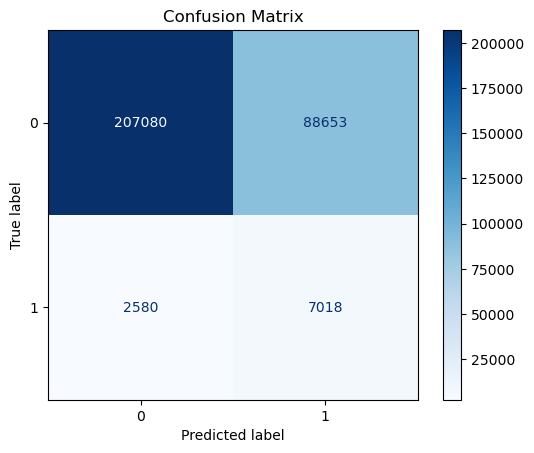

In [186]:
y_pred_labels = fitted_models[2].predict(X_valid)  # Use predict() for class labels directly

# Generate confusion matrix
cm = confusion_matrix(y_valid, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

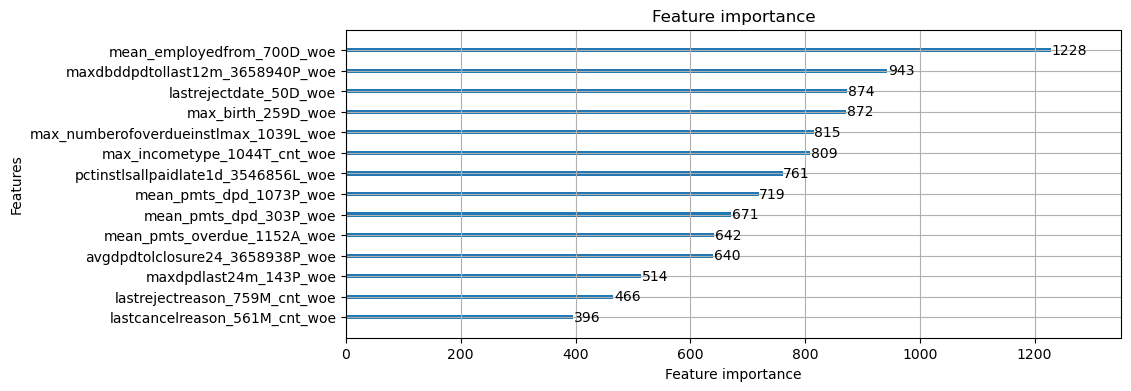

In [159]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,4))
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


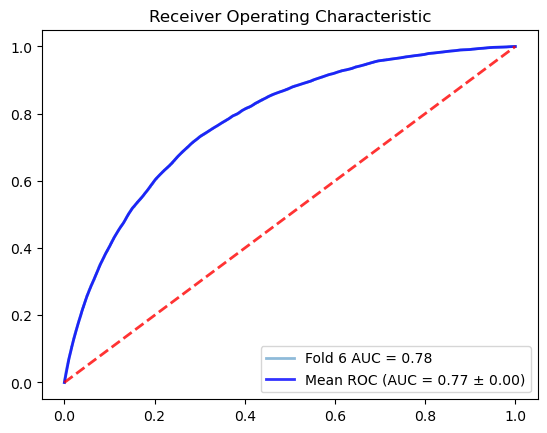

CV AUC scores:  [0.7692721764538448, 0.7715316067254401, 0.7714838341400583, 0.7708493604570098, 0.7701614851674293, 0.7826543146312362]
Maximum CV AUC score:  0.7826543146312362


In [150]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
tprs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

y_pred_proba = fitted_models[2].predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)
cv_scores.append(roc_auc)

# Interpolate the TPR (true positive rate) for the current fold
interp_tpr = np.interp(mean_fpr, fpr, tpr)
interp_tpr[0] = 0.0  # Set the first point in the interpolated TPR to zero
tprs.append(interp_tpr)

# Plot the ROC curve for the current fold
ax.plot(fpr, tpr, label=f'Fold {len(cv_scores)} AUC = {roc_auc:.2f}', lw=2, alpha=0.5)

# Compute the mean AUC and mean interpolated TPR
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Set the last point in the interpolated TPR to one
mean_auc = np.mean(cv_scores)
std_auc = np.std(cv_scores)

# Plot the mean ROC curve
ax.plot(mean_fpr, mean_tpr, color='b',
        label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
        lw=2, alpha=0.8)

# Plot the chance line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# Customize the plot
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

# Output the cross-validation AUC scores
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))




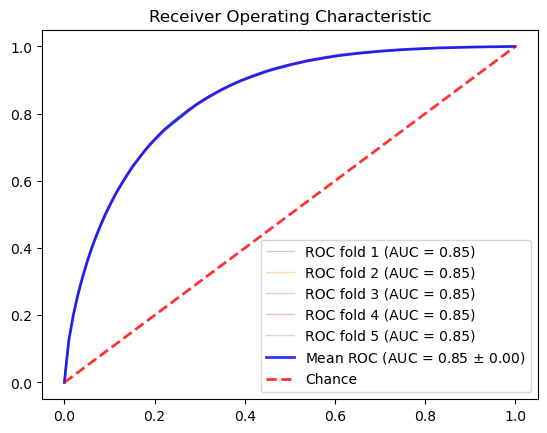

Mean AUC Score: 0.8470532830477996


In [127]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
weeks = df_train["WEEK_NUM"]
X = df_train
y = df_train['target']
X = X.drop(columns=["target", "case_id", "WEEK_NUM"])
def run_lgbm_cv_with_oversampling(X, y, n_splits=5, num_boost_round=100):
    """
    Train a LightGBM model with cross-validation and plot ROC curves.
    Includes oversampling for handling class imbalance.

    Parameters:
    - X: Features DataFrame.
    - y: Target variable Series.
    - n_splits: Number of folds for cross-validation.
    - num_boost_round: Number of boosting rounds.

    Returns:
    - Prints out the mean AUC score and plots ROC curves for each fold.
    """
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fig, ax = plt.subplots()
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    ros = RandomOverSampler(random_state=42)

    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply oversampling to the training data
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

        # Create dataset for LightGBM
        train_data = lgb.Dataset(X_train_res, label=y_train_res)
        validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

        # Define parameters for LightGBM
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'learning_rate': 0.1,
            'verbose': 0
        }

        # Train the model
        bst = lgb.train(params, train_data, num_boost_round, valid_sets=[validation_data])

        # Predict test set
        y_pred_proba = bst.predict(X_test)

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

        # Interpolate all ROC curves at this points
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    # Plot the average ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='blue',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=0.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    plt.show()

    return mean_auc

# Example usage
mean_auc_score = run_lgbm_cv_with_oversampling(X, y)
print("Mean AUC Score:", mean_auc_score)


max_incometype_1044T_cnt_woe  mean_pmts_dpd_303P_woe  \
692809                       0.222649               -0.001084   
1002937                      0.222649               -0.759893   
235540                       0.222649               -0.001084   
989213                       0.158360               -0.759893   
239964                       0.222649               -0.001084   
...                               ...                     ...   
271496                       0.158360               -0.001084   
918060                      -0.556503                0.670125   
1412120                     -0.556503               -0.759893   
1385490                     -0.556503               -0.001084   
1328061                     -0.133298                0.670125   

         mean_pmts_overdue_1152A_woe  lastcancelreason_561M_cnt_woe  \
692809                     -0.001109                      -0.257678   
1002937                    -0.782143                       0.581545   
235540                     -0.001109                      -0.257678   
989213                     -0.235204                      -0.257678   
239964                     -0.001109                      -0.257678   
...                              ...                            ...   
271496                     -0.001109                      -0.257678   
918060                      0.632170                      -0.257678   
1412120                    -0.782143                       0.089704   
1385490                    -0.001109                       0.581545   
1328061                     0.632170                      -0.257678   

         max_birth_259D_woe  mean_employedfrom_700D_woe  \
692809             0.050180                    0.515950   
1002937            0.050180                   -0.200550   
235540             0.050180                   -0.200550   
989213             0.050180                    0.175677   
239964            -0.191411                   -0.200550   
...                     ...                         ...   
271496             0.050180                   -0.574062   
918060            -0.540805                   -0.127824   
1412120           -0.540805                   -0.574062   
1385490           -0.540805                   -0.127824   
1328061            0.050180                   -0.574062   

         avgdpdtolclosure24_3658938P_woe  maxdpdlast24m_143P_woe  \
692809                         -0.496113               -0.177920   
1002937                        -0.496113               -0.177920   
235540                         -0.065876               -0.370821   
989213                         -0.496113               -0.177920   
239964                         -0.065876               -0.370821   
...                                  ...                     ...   
271496                         -0.065876               -0.177920   
918060                         -0.496113               -0.177920   
1412120                        -0.496113               -0.177920   
1385490                         0.372260               -0.177920   
1328061                         1.144349                1.047332   

         mean_pmts_dpd_1073P_woe  pctinstlsallpaidlate1d_3546856L_woe  \
692809                  0.057902                            -0.609562   
1002937                -0.444969                            -0.609562   
235540                  0.803228                            -0.075837   
989213                 -0.444969                            -0.080544   
239964                  0.803228                            -0.075837   
...                          ...                                  ...   
271496                 -0.444969                            -0.075837   
918060                 -0.444969                             0.420679   
1412120                -0.444969                            -0.609562   
1385490                -0.444969                            -0.609562   
1328061                 0.803228              